<a href="https://colab.research.google.com/github/MarcosRMG/Bootcamp-Alura-Data-Science/blob/main/Projeto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


<font size=6>**Machine Learning aplicado aos dados clínicos da COVID-19 do hospital Sírio Libanês**</font>


---



Autor: Marcos Galvão

[Linkedin](https://br.linkedin.com/in/marcosrmgalvao)

[Github](https://github.com/MarcosRMG)

[Blog Jogando com Dados](https://jogandocomdados.blogspot.com/)


---

# Apresentação

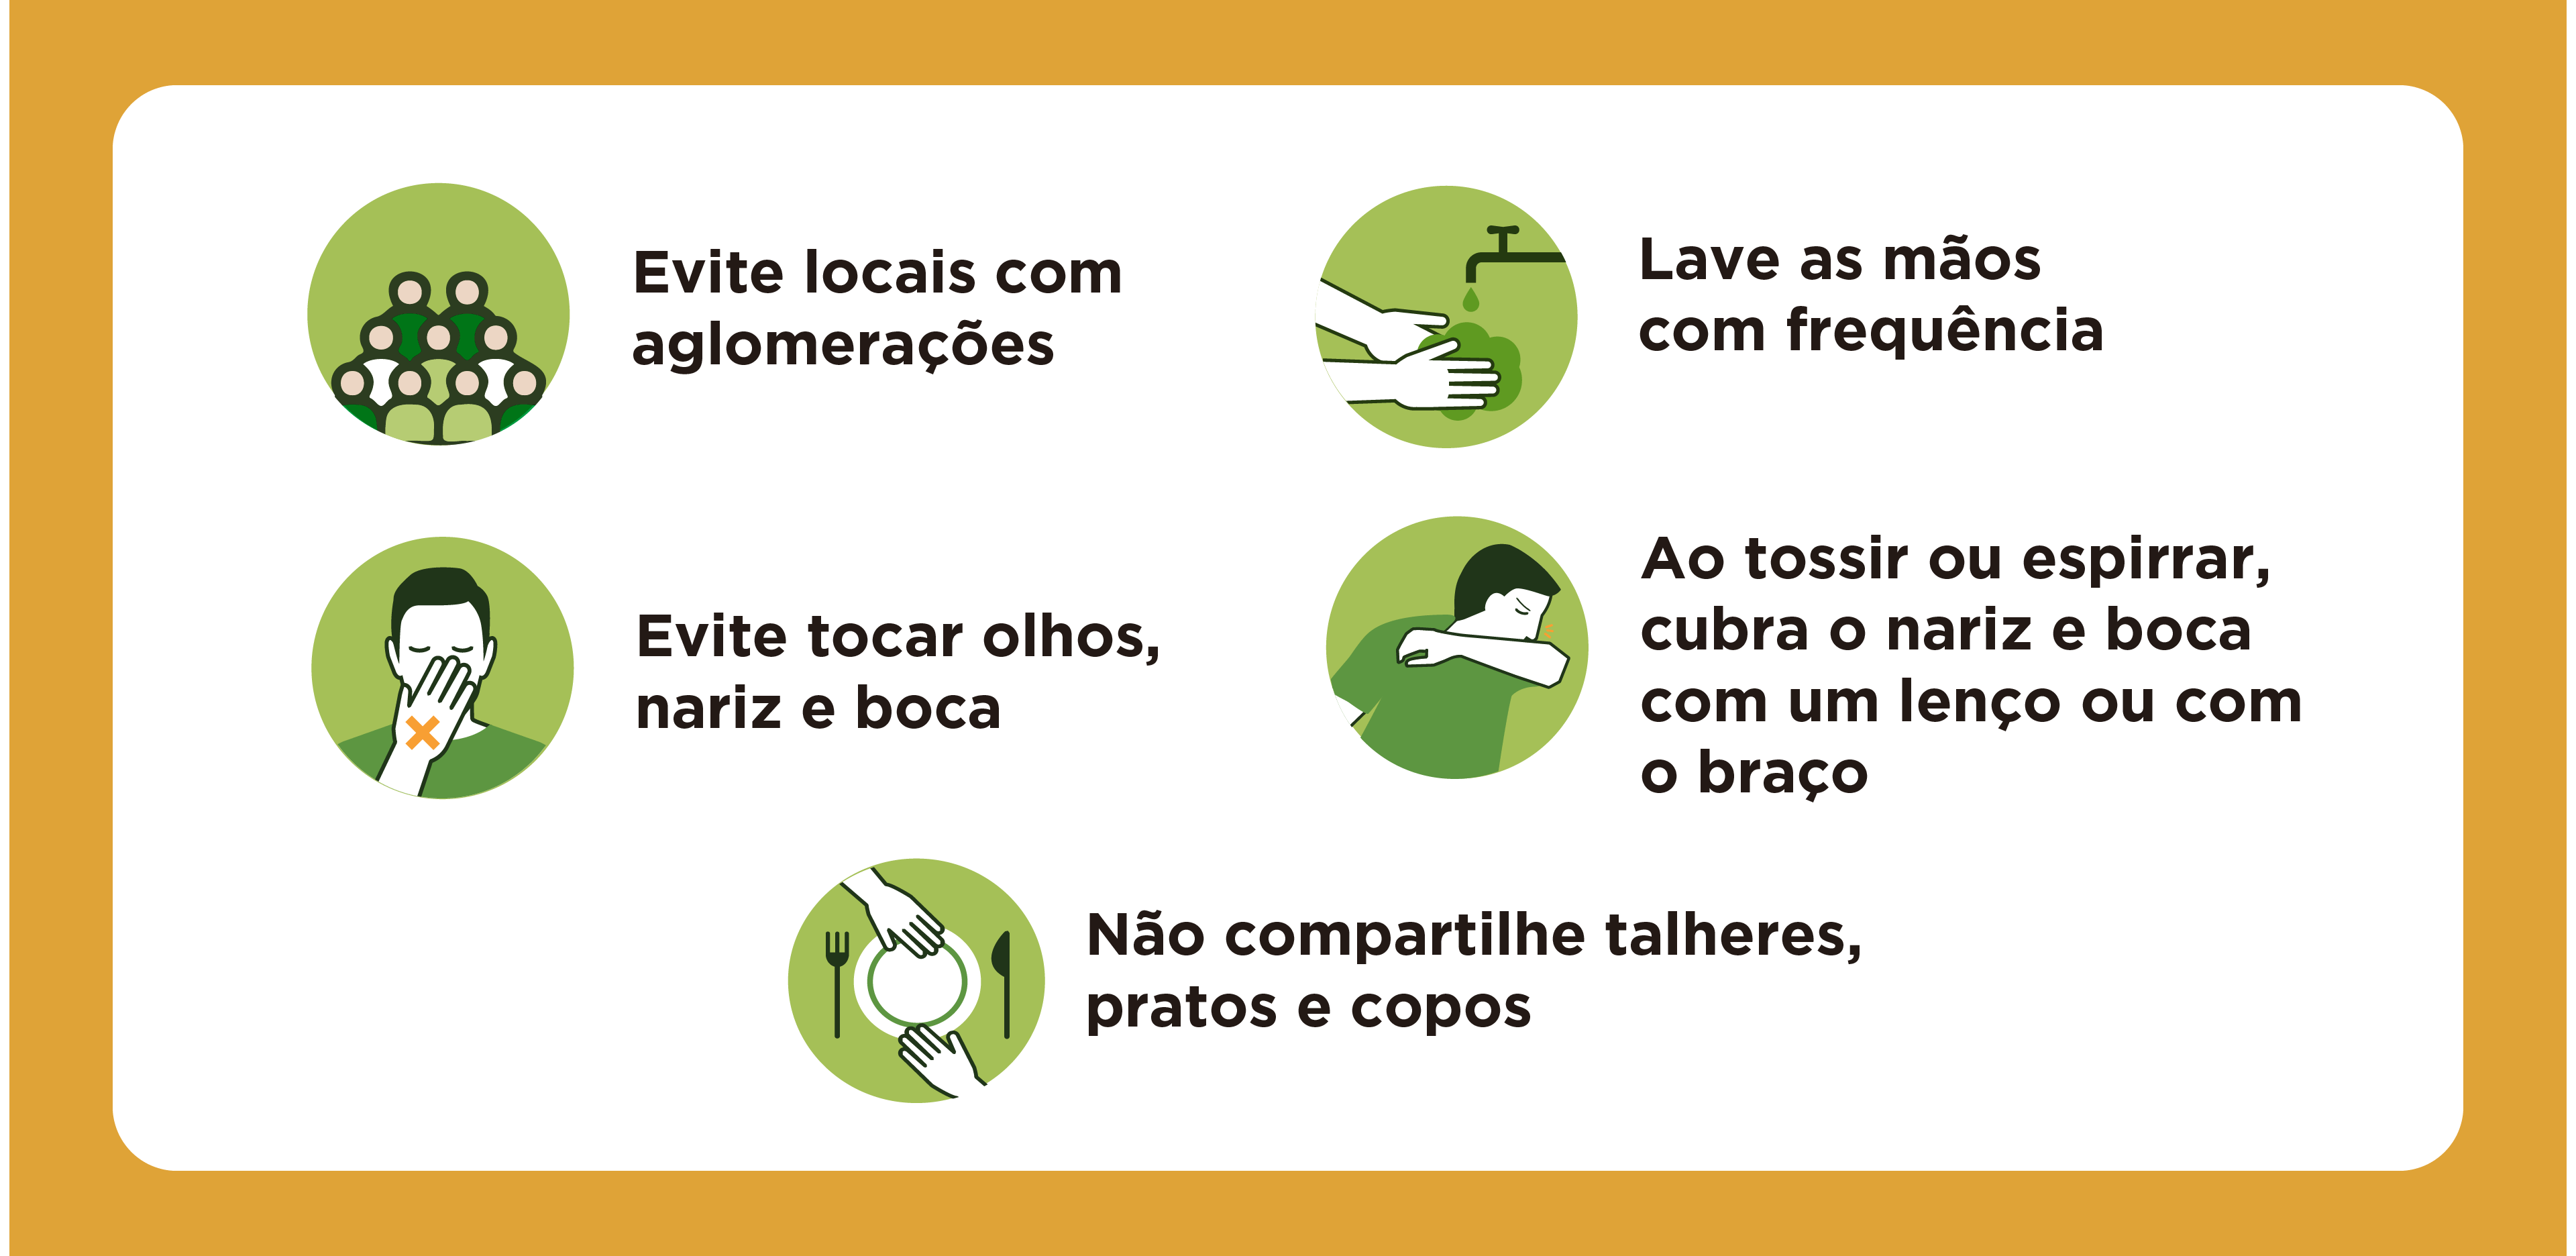

A COVID-19 registrou o primeiro caso de infecção no dia 12 de dezembro de 2019 em Wuhan na China. No dia 11 de março de 2020 a Organização Mundial da Saúde declarou a doença como pandêmica.

Considerando até o dia 21 de fevereiro de 2021 a doença já contaminou 111.319.845 pessoas e causou 2.465.258 mortes em todo o mundo. (Johns Hopkins, 2021).

Os países com o maior número de casos são os Estados Unidos da América, Índia e Brasil, o maior número de óbitos foram registrados nos Estados Unidos da América, Brasil e México.

Uma vez declarada a pandemia todos os países tiveram que adotar medidas que freassem o surgimento de novas infecções, sendo as medidas de distanciamento, higiene pessoal (principalmente o uso de álcool em gel nas mãos) e o uso de máscara os principais meios adotados.

A doença causou e continua causando um impacto econômico, social e sanitário global exigindo que recursos e capital humano sejam mobilizados para combater o vírus e estabelecer um retorno seguro ao convívio social que estávamos acostumados antes da pandemia.

Uma das demandas mais emergentes frente a COVID-19 é a utilização de leitos de UTI para tratamento de pacientes em situação de agravamento, requerendo uma mobilização do sistema de saúde para acolhimento dessas pessoas, frente a esse cenário foi desenvolvido aqui uma pesquisa que buscou identificar um modelo de Machine Learning que pudesse prever se o paciente irá precisar da UTI ou não, os dados utilizados foram disponibilizados pelo hospital Sírio Libanês na comunidade online Kaggle.

Deixo o meu agradecimento a organização [Alura](https://www.alura.com.br/) e todos os colaboradores e estudantes envolvidos no Bootcamp de Data Science Aplicada que possibilitou que esse projeto fosse desenvolvido e espero que esse trabalho possa servir de referência para novos estudos relacionado ao tema e novos projetos de Data Science.

# 1 Resumo

O seguinte trabalho utilizou os dados disponibilizados pelo hospital Sírio Libanês, contendo informações demográficas, grupos de doenças, exames de sangue e sinais vitais dos pacientes que foram diagnosticados com COVID-19, da amostra disponibilizada aproximadamente 50% (46% após o tratamento dos dados) precisaram da UTI. O objetivo central é prever se o paciente ao dar entrada no hospital irá precisar da UTI ou não, essa ferramenta possibilita que ações preventivas sejam tomadas, desde aquisição de recursos ou transferência de pacientes em caso de utilização de toda a capacidade instalada do hospital.

Uma informação importante que a previsão fornece é quais os fatores são determinantes para que o paciente precise ou não da UTI, podendo assim munir os agentes de saúde a tomar ações que aumentem a imunidade do paciente e consequentemente elimine a necessidade da UTI.

**2 Tratamento dos dados:** Foram consideradas as linhas que se referem a janela de exames de 0-2 horas, pois quanto mais cedo for a previsão melhor.

**3 Análise Exploratória:** Foi observado como se dá a distribuição das informações para os pacientes que foram e não foram para UTI, neste tópico foi possível a geração de um novo conjunto de dados, onde foram desconsideradas as colunas que apresentam a mesma distribuição para os pacientes que foram e não foram para UTI.

**4 Modelos de Machine Learning:** As previsões foram realizadas com dois conjuntos de dados, o primeiro conjunto contém todas as colunas e o segundo apenas as colunas que estatisticamente apresentam distribuição diferente para os dois grupos (foi para UTI X não foi para UTI), dos modelos utilizados o Random Forest Classifier apresentou o melhor AUC com 79%. As featurer importances de maior impacto do model Random Forest foram a pressão arterial diastólica mínima e média, PCR (proteína C-reativa) e creatina mediana, sendo estes os fatores que mais influenciam a levar o paciente e ser encaminhado ou não para UTI.

Para que o modelo pudesse ser levado a produção seria necessário a replicação do mesmo em um conjunto de dados mais amplo, e a validação de profissionais da saúde para os principais fatores de decisão (featurer importances) utilizados pelo algoritmo.

<font size=5>**Fluxograma do Projeto**</font>

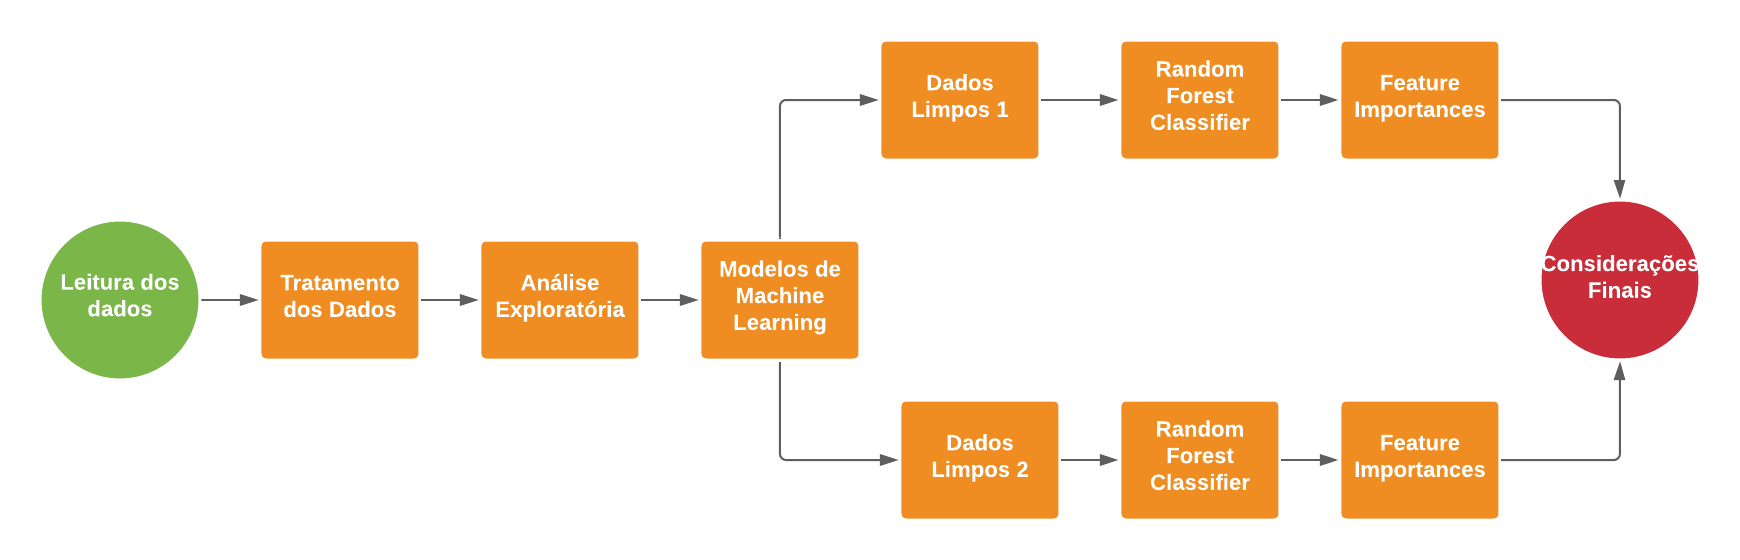

# 2 Tratamento dos Dados

## 2.1 Bibliotecas

In [ ]:
# Tratamento
import pandas as pd
import numpy as np
import warnings

# Visualização
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

#Testes de hipótese
from scipy.stats import ranksums
from scipy.stats import normaltest
from statsmodels.stats.weightstats import ztest

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Estratégia de estratificação
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

# Métricas de avaliação
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# Personalizando visualizações
matplotlib.rcParams['figure.figsize'] = [14, 8]
sns.set_theme(style='whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2.2 Funções

### 2.2.1 Personaliza gráfico

In [ ]:
def personaliza_grafico(titulo:str, x_label: str, y_label: str):
  '''
  Define as informações descritivas do gráfico

  Keywords arguments
  titulo: Título do gráfico
  x_label: Descrição do eixo x do gráfico
  y_label: Descrição do eixo y do gráfico
  '''
  plt.title(titulo, loc='left', fontsize=24)
  plt.xlabel(x_label, fontsize=18)
  plt.ylabel(y_label, fontsize=18);

### 2.2.2 Tabela de frequência

In [ ]:
def tabela_frequencia(dados: pd.DataFrame, coluna: str, titulo: str):
  '''
  Calcula a tebela de frequência da série de dados

  Keywords arguments
  dados: DataFrame contendo as informações para cálculo
  coluna: Serie pandas do DataFrame com as informações desejadas
  titulo: Título descritivo do eixo/ tabela

  return: DataFrame com as informações de frequência e percentual
  '''
  frequencia = dados[coluna].value_counts(ascending=False)
  percentual = round(dados[coluna].value_counts(normalize=True, ascending=False) * 100, 1)
  _ = pd.DataFrame(
      {'Frequencia': frequencia,
      'Percentual %': percentual})
  return _.rename_axis(titulo)

### 2.2.3 Gráfico de pizza

In [ ]:
def grafico_pizza(dados: pd.DataFrame, valores: str, nomes: str, titulo: str):
  '''
  Plota o gráfico de pizza

  Keywords arguments
  dados: DataFrame contendo os valores desejados
  valores: Coluna do DataFrame com os valores em série
  nomes: Descrição das variáveis
  titulo: Título descritivo do gráfico
  '''
  px.pie(dados, values=valores, names=nomes, 
       title=titulo)

### 2.2.4 Preenche tabela

In [ ]:
def preenche_tabela(dados):
  '''
  A função irá preencher as linhas que estão com valores NaN com as linhas
  antecedentes e subsequentes referente a mesmo pacientes considerando a linha
  que ICU seja igual a 1

  Keywords arguments:
  dados: DataFrame com as informações disponibilizadas pelo hospital Sírio 
  Libanês

  return: Colunas preenchidas com os dados das linhas antecedentes ou 
  subsequentes do valor NaN
  '''
  features_continuas_colunas = dados.iloc[:, 13:-2].columns
  features_continuas = dados.query('ICU == 0').groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
  features_categoricas = dados.iloc[:, :13]
  saida = dados.iloc[:, -2:]
  dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
  dados_finais.columns = dados.columns
  return dados_finais

### 2.2.5 Atribuição do valor a primeira janela

In [ ]:
def prepare_window(rows):
  '''
  A função irá varer as linhas e identificar em qual linha a coluna ICU (UTI) é
  igual a 1, e atribuir esse valor para a linha WINDOW = 0-2
  '''
  if np.any(rows['ICU']):
    rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
  return rows.loc[rows['WINDOW'] == '0-2']

### 2.2.6 Prepara DataFrame WINDOW == 1

In [ ]:
def selecao_janela_1(dados: pd.DataFrame, 
                    identificacao_paciente='PATIENT_VISIT_IDENTIFIER',
                    janela='WINDOW'):
  '''
  Exclui os pacientes com ICU = 1 e WINDOW = 0-2, atribui o valor 1 a primeira 
  janela dos pacientes que foram para UTI nas janelas subsequentes, e exclui as 
  colunas e índices desnecessários.

  Keywords arguments
  dados: DataFrame completo com os valores NaN preenchidos
  identificacao_paciente: Coluna que identifica o paciente (visitante)
  janela: Coluna que identifica a janela de coleta de informações sobre o 
  paciente

  return: A primeira janela (WINDOW == 0-2), atribuíndo o valor
  1 para os pacintes que foram para a UTI nas janelas subsequentes
  '''
  dados.drop(dados.query('ICU == 1 and WINDOW == "0-2"')['PATIENT_VISIT_IDENTIFIER'].values,
             inplace=True)
  dados = dados.groupby(identificacao_paciente, as_index=False).apply(prepare_window)
  dados.drop([identificacao_paciente, janela], inplace=True, axis=1)
  dados = dados.droplevel(1)
  return dados

### 2.2.7 Teste de normalidade

[scipy.stats.normaltest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html?highlight=normaltest#scipy.stats.normaltest)

In [ ]:
def teste_normalidade(dados: pd.DataFrame, coluna: pd.Series, descricao_coluna: str):
  '''
  Retorna o resultado do teste de normalidade

  Keywords arguments
  dados: DataFrame com os dados para teste
  coluna: Coluna do DataFrame que será testada
  descricao_coluna: Descrição da variável que está sendo testada 
  '''
  _, p_value = normaltest(dados[coluna],
                        nan_policy='omit')
  if p_value < 0.05:
    print(f'''
P-value do teste de normalidade da varirável {descricao_coluna}: {p_value:.2f}
P-value < 0.05 = {p_value < 0.05}
Não se trata de uma distribuição normal.
''')
  else:
    print(f'''
P-value do teste de normalidade da varirável {descricao_coluna}: {p_value:.2f}
P-value < 0.05 = {p_value < 0.05}
Se trata de uma distribuição normal.
''')

### 2.2.8 Teste Ranksums

[scipy.stats.randsums](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html?highlight=ranksums)

In [ ]:
def teste_ranksums(dados: pd.Series, coluna: str, descricao_coluna):
  '''
  Teste Ranksums do grupo que foi e não foi para a UTI

  Keywords arguments:
  dados: DataFrarme com os dados dos pacientes que foram e não foram
  para UTI
  coluna: Coluna do DataFrame para ser testada
  descricao_coluna: Descrição da variável que está sendo testada
  '''
  _, p_value = ranksums(dados.query('ICU == 0')[coluna],
         dados.query('ICU == 1')[coluna])
  
  if p_value < 0.05:
    print(f'''
Coluna: {descricao_coluna}
P-value: {p_value:.2f} 
P-value < 0.05 = {p_value < 0.05}
Resultado: Mesma distribuição = NÃO.
''')
  else:
    print(f'''
Coluna: {descricao_coluna}
P-value: {p_value:.2f} 
P-value < 0.05 = {p_value < 0.05}
Resultado: Mesma distribuição = SIM.
''')

### 2.2.9 Altera valores do index

In [ ]:
def altera_valores_index(dados: pd.DataFrame, antigo_index: str, 
                         dicionario_valores: dict):
  '''
  Altera os valores do index para um formato descritivo
  
  Keyword arguments
  dados: DataFrame com os dados para alteração do index
  antigo_index: Coluna com os valores do antigo index
  dicionario_valores: Dicionário com o mapeamento dos valores

  return: Novo DataFrame com o index descritivo
  '''
  dados.reset_index(inplace=True)
  dados[antigo_index] = _[antigo_index].map(dicionario_valores)
  _.set_index(antigo_index, inplace=True)
  return _

### 2.2.10 Teste Ranksums das colunas

In [ ]:
def teste_ranksums_colunas(dados: pd.DataFrame, colunas: list, 
                           variacao_colunas_1=False, variacao_colunas_2=False, 
                           distribuicoes='Foi para UTI x Não foi para UTI'):
  '''
  Realiza o teste Ranksums em um bloco de colunas

  Keywords arguments
  dados: DataFrame com os dados para teste
  colunas: Lista com parte da descrição da coluna que se repete nas demais 
  colunas
  variacao_colunas_1: Variação em cada descrição geral das colunas
  referente aos sinais vitais
  variacao_colunas_2: Descrição geral das colunas referente
  aos exames de sangue 
  distribuições: Descrição das distribuições que estão sendo testadas
  '''
  print('                    TESTES RANKSUMS')
  print('')
  print(distribuicoes)
  print('')
  if variacao_colunas_1:
    for i in colunas:
      coluna = i + '_' + variacao_colunas_1
      teste_ranksums(dados, coluna, coluna) 
  elif variacao_colunas_2:
    for i in colunas:
      coluna = variacao_colunas_2 + '_' +  i 
      teste_ranksums(dados, coluna, coluna) 

### 2.2.11 Varáveis com a mesma distribuição

In [ ]:
def mesma_distribuicao_colunas(dados: pd.DataFrame):
  '''
  Realiza o teste de normalidade e se a distribuição for ou não normal a função
  verifica a iguldade da distribuição referente aos pacientes que foram ou não
  para UTI.

  Keywords arguments
  dados: DataFrame com os dados para teste

  return: Lista com as colunas que possuem a mesma distribuição referente
  aos pacintes que foram e não foram para UTI
  '''
  mesma_distribuicao = list()
  for i in dados.columns:
    _, p_value = normaltest(dados[i])
    # Se não for uma distribuição normal
    if p_value < 0.05:
      _, p_value = ranksums(dados.query('ICU == 0')[i], dados.query('ICU == 1')[i])
      # Se as distribuições forem iguais
      if p_value >= 0.05:
        mesma_distribuicao.append(i)
    # Se for uma distribuição normal    
    elif p_value > 0.05:
      _, p_value = ztest(dados.query('ICU == 0')[i], dados.query('ICU == 1')[i])
      # Se as distribuições forem iguais
      if p_value >= 0.05:
        mesma_distribuicao.append(i)
  return mesma_distribuicao

### 2.2.12 Modelo cv

In [ ]:
def roda_modelo_cv(dados: pd.DataFrame, y='ICU', 
                x_drop=['ICU'],
                modelo=DecisionTreeClassifier(), n_splits=5, n_repeats=10,
                descricao_modelo='Decision Tree Classifier'):
  '''
  Realiza a validação cruzada

  Keyword arguments
  dados: DataFrame com as informações para treino e teste
  y: Coluna do DataFrame atribuída a variável y
  x_drop: Colunas do DataFrame que devem ser desconsidradas na variável x
  modelo: Modelo para classificação
  n_splits: Número de partes que o DataFrame será divido para validação 
  n_repeats: Número de vezes que o modelo será treinado
  descricao_modelo: Descrição do modelo utilizado

  return: Média do auc de teste e de treino
  '''
  
  np.random.seed(2933)
  dados = dados.sample(frac=1).reset_index(drop=True)
  y = dados[y]
  x = dados.drop(x_drop, axis=1)

  modelo = modelo
  
  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultado = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', 
                             return_train_score=True)

  media_teste = np.mean(resultado['test_score'])
  media_treino = np.mean(resultado['train_score'])

  print(f'AUC teste/ treino: {media_teste:.2f} - {media_treino:.2f}')
  return media_teste, media_treino

### 2.2.13 Plota curva AUC

In [ ]:
def curva_auc(media_teste: list(), media_treino: list(), descricao_modelo: str, 
              n_repeats_x=10):
  '''
  Plota o gráfico com o resultado de AUC de treino e teste

  Keyword arguments
  n_repeats_x: Número de repetições do modelo
  media_treino: Resultado médio do AUC de treino
  descricao_modelo: Descrição do modelo utilizado
  '''
  x = range(1, n_repeats_x)
  plt.figure(figsize=(16, 8))
  plt.plot(x, media_teste, label='AUC Teste', )
  plt.plot(x, media_treino, label='AUC Treino')
  plt.title(descricao_modelo, loc='left', fontsize=24)
  plt.legend();

### 2.2.14 Retorna modelo, teste, treino e predict

In [ ]:
def modelo_treino_teste(dados: pd.DataFrame, y='ICU', x_drop=['ICU'], 
                        modelo=RandomForestClassifier()):
  '''
  Realiza a estratificação dos dados de treino e teste e retorna o modelo 
  ajusdado aos dados de treino

  Keyword arguments
  dados: DataFrame com as informações para treino e teste
  y: Coluna do DataFrame atribuída a variável y
  x_drop: Colunas do DataFrame que devem ser desconsidradas na variável x
  modelo: Modelo para classificação

  return: Modelo de ML treinado, x de treino e teste, y de treino e y previsto
  '''
  
  seed = np.random.seed(2933)
  dados = dados.sample(frac=1).reset_index(drop=True)
  y = dados[y]
  x = dados.drop(x_drop, axis=1)
  
  x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=.3, 
                                                      random_state=seed, 
                                                      stratify=y)
  modelo.fit(x_treino, y_treino)
  y_predito = modelo.predict(x_teste)

  return modelo, x_treino, x_teste, y_treino, y_teste, y_predito

## 2.3 Leitura e limpeza dos dados

In [ ]:
'''
dados: Informações disponibilizadas pelo hospital Sírio Libanês
''' 
dados = pd.read_csv('https://raw.githubusercontent.com/MarcosRMG/Bootcamp-Alura-Data-Science/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.csv',
                    thousands='.', decimal=',')

In [ ]:
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
'''
dados_limpos: Informações disponibilizadas pelo hospital Sírio Libanês com os
seguintes tratamentos;

1. Preenchimento dos valores NaN considerando as linhas antecedentes e 
subsequentes do histórico do pacinete (visitante), as informações das linhas com 
ICU = 1 não foram utilizadas;
2. Seleção da primeira janela (WINDOW == 0-2) e atribuição do valor 1 aos 
pacientes que foram para UTI nas janelas subsequentes
3. Codificação da coluna AGE_PERCENTIL
4. Exclusão das linhas com valores NaN
'''
dados_limpos = preenche_tabela(dados)
dados_limpos = selecao_janela_1(dados_limpos)
dados_limpos.dropna(inplace=True)
dados_limpos.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.978029,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.978029,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,-1.000000,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.88366

# 3 Análise Exploratória

**Questão Central** 

Como se dá a distribuição dos pacientes que foram e não forma para UTI nas colunas do DataFrame?

**Objetivo**

Identificar as variáves que apresentam o mesmo comportamento ou comportatmento contrário a regrar observada para os grupos que foram e não foram para a UTI, pois essas informações podem impactar no modelo de Machine Learning.

## 3.1 Dados

O DataFrame contém informação das seguintes categorias referente ao paciente. 

1.   Informações demográficas do paciente
2.   Grupos de doênças prévias do paciente
3. Exames de sangue
4. Sinais vitais
5. Gases sanguínios

Cada linha do DataFrame representa uma janela de tempo de duas horas, onde cada paciente pode ter dados de 0 a 2 horas até 12 horas ou mais. 

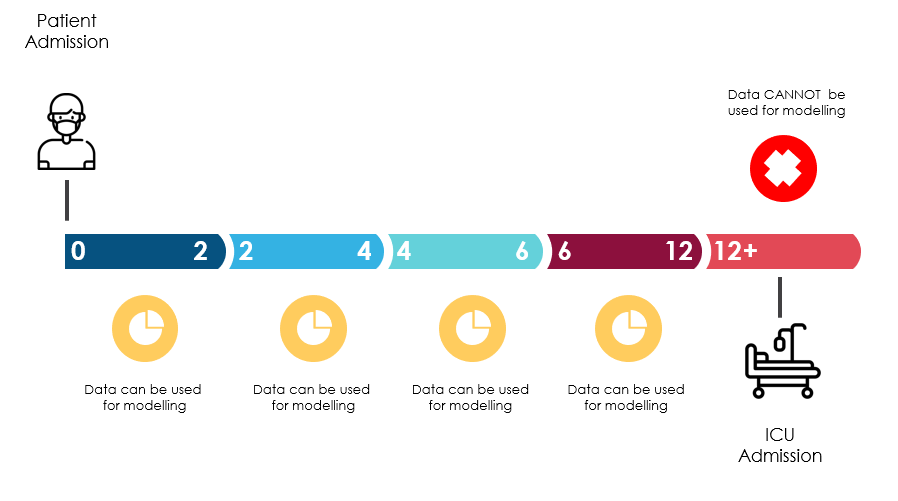

A coluna ICU contém a informação se o paciente foi internado na UTI (Unidade de Terapia Intensiva) ou não. 

O objetivo é prever com base nos resultados dos exames se o paciente vai ou não para a UTI, essa informação é relevante para que o hospital(ais) possa (am) planejar a provisão de recursos ou transferência de pacientes para outros hospitais. 

O hospital Sírio Libanês destaca que as informações das linhas com ICU = 1 (confirma que o paciente foi para UTI) não devem ser consideradas nos modelos de Machine Learning, pois os exames podem ter sido realizados após interção, e a previsão deve ser realizada antes da interação.

In [ ]:
'''
Linhas: Número de pacientes (visitantes)
Colunas: Informações sobre os pacientes (visitantes)
'''
print(f'Número de linhas: {dados_limpos.shape[0]}')
print(f'Número de colunas: {dados_limpos.shape[1]}')

Número de linhas: 350
Número de colunas: 229


In [ ]:
tabela_frequencia(dados_limpos, 'ICU', 'UTI')

,Frequencia,Percentual %
UTI,,
0,189,54.0
1,161,46.0


In [ ]:
_ = pd.DataFrame({'Pacientes': [161, 189]}, index=['Foram para a UTI', 'Não forma para a UTI'])
px.pie(_, values='Pacientes', names=_.index, 
       title='Pacientes(visitantes) que foram ou não para a UTI')

**Observações**



1.   A coluna PATIENT_VISIT_IDENTIFIER em um cenário ideal representa a identificação de cada paciente, mas não há garantia que a mesma pessoa não tenha recebido duas identificações, pois a identificação considera a visita do indivíduo, o mesmo indivíduo pode ter ido até o hostítal mais de uma vez e entrado na amostra.
2.   Cada visitante é representado em cinco linhas consecutivas no DataFrame.
3.   Após o tratamento dos dados a amostra ficou dividida em 54% que não foram para UTI e 46% que foram para UTI.


## 3.2 Dados demográficos

In [ ]:
# Colunas referente as informações demográficas do paciente
dados.columns[1:4]

Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER'], dtype='object')

Descrição das colunas

AGE_ABOVE65: Idade acima de 65 anos

AGE_PERCENTIL: Percentil da idade

GENDER: Gênero (anonimizado)

In [ ]:
'''
dados_demograficos: Contêm as informações demográficas dos pacientes
'''
# Seleção das colunas
dados_demograficos = dados_limpos[['AGE_ABOVE65', 
                            'AGE_PERCENTIL', 'GENDER', 'ICU']]
dados_demograficos.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,ICU
0,1,60th,0,1
2,0,10th,0,1
3,0,40th,1,0
4,0,10th,0,0
5,0,10th,0,0


### 3.2.1 Idade maior do que 65 anos

In [ ]:
'''
nao_sim: Dicionário com o significado dos valores 0 e 1
'''
nao_sim = {
    0: 'Não',
    1: 'Sim'
}

In [ ]:
_ = tabela_frequencia(dados_demograficos, 'AGE_ABOVE65', 
                      'Idade superior a 65 anos')
altera_valores_index(_, 'Idade superior a 65 anos', nao_sim)

,Frequencia,Percentual %
Idade superior a 65 anos,,
Não,189,54.0
Sim,161,46.0


Nota se um equilíbrio na distribuição das idades superior e inferior a 65 anos, onde espera-se que 0 signifique não e 1 signifique sim.

In [ ]:
_ = pd.DataFrame({
    'Foi para UTI': round(dados_demograficos.query('ICU == 1')['AGE_ABOVE65'].value_counts(normalize=True) * 100, 1),
    'Não foi para UTI': round(dados_demograficos.query('ICU == 0')['AGE_ABOVE65'].value_counts(normalize=True) * 100, 1)
})
_.rename_axis('Idade superior a 65 anos', inplace=True)
altera_valores_index(_, 'Idade superior a 65 anos', nao_sim)

,Foi para UTI,Não foi para UTI
Idade superior a 65 anos,,
Não,37.9,67.7
Sim,62.1,32.3


Nota se uma situação quase que inversa no que diz respeito a idade do paciente (visitante), onde o grupo que foi para a UTI marjoritariamente (62%) possui mais do que 65 anos, já o grupo que não foi para a UTI minoritariamente (32%) possui mais do que 65 anos, por esse motivo que os idosos fazem parte do grupo de risco. 

### 3.2.2 Percentil da idade

In [ ]:
'''
Variável: Formato categórico da coluna AGE_PERCENTIL
'''
percentil_idade = {
    '10th': 0, 
    '20th': 1, 
    '30th': 2, 
    '40th': 3, 
    '50th': 4, 
    '60th': 5,
    '70th': 6, 
    '80th': 7,
    '90th': 8,
    'Above 90th': 9}

In [ ]:
tabela_frequencia(dados_demograficos, 'AGE_PERCENTIL', 'Percentil das idades')

,Frequencia,Percentual %
Percentil das idades,,
20th,41,11.7
30th,39,11.1
40th,37,10.6
10th,37,10.6
80th,36,10.3
70th,34,9.7
50th,34,9.7
Above 90th,34,9.7
60th,30,8.6


In [ ]:
print(f'''
Média do número de pacientes por percentil de idade: {round(dados_demograficos['AGE_PERCENTIL'].value_counts().values.mean())}
Desvio padrão do número de pacientes por percentil das idades: {round(dados_demograficos['AGE_PERCENTIL'].value_counts().values.std())}
''')


Média do número de pacientes por percentil de idade: 35
Desvio padrão do número de pacientes por percentil das idades: 4



O percentil das idades foram distribuídos  de forma aproximada entre as classes.

Com número médio de pacientes por percentil de idade de 35 e desvio padrão de 4.


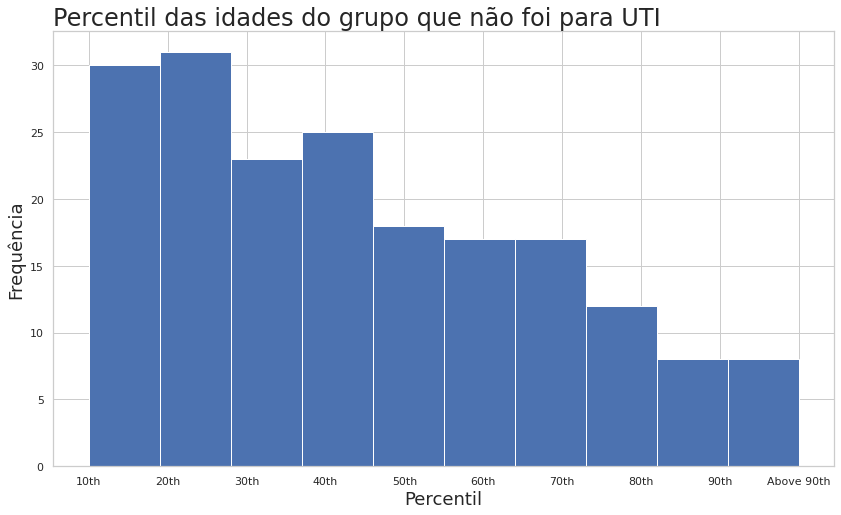

In [ ]:
plt.hist(x=dados_demograficos.query('ICU == 0')['AGE_PERCENTIL'].map(percentil_idade))
personaliza_grafico('Percentil das idades do grupo que não foi para UTI',
                    'Percentil', 'Frequência')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['10th', '20th', '30th', '40th', '50th',
                                            '60th', '70th', '80th', '90th', 
                                            'Above 90th']);

In [ ]:
tabela_frequencia(dados_demograficos.query('ICU == 0'), 'AGE_PERCENTIL', 
                  'Percentil da idade/ não foi para UTI')

,Frequencia,Percentual %
Percentil da idade/ não foi para UTI,,
20th,31,16.4
10th,30,15.9
40th,25,13.2
30th,23,12.2
50th,18,9.5
60th,17,9.0
70th,17,9.0
80th,12,6.3
Above 90th,8,4.2


O grupo que não foi para a UTI apresenta uma maior distribução nos percentis de 20, 10 e 40 anos, caracterizando uma distribução assimétrica a esquerda.

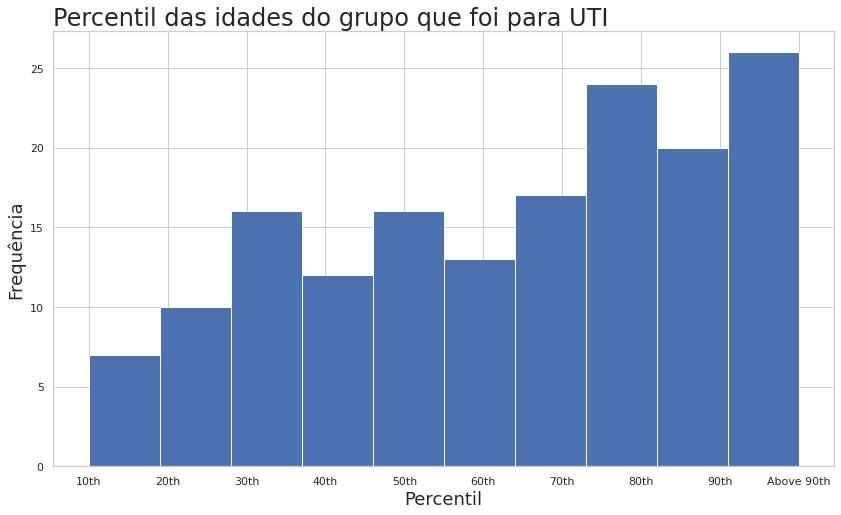

In [ ]:
plt.hist(x=dados_demograficos.query('ICU == 1')['AGE_PERCENTIL'].map(percentil_idade))
personaliza_grafico('Percentil das idades do grupo que foi para UTI',
                    'Percentil', 'Frequência');
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['10th', '20th', '30th', '40th', '50th',
                                            '60th', '70th', '80th', '90th', 
                                            'Above 90th']);

In [ ]:
tabela_frequencia(dados_demograficos.query('ICU == 1'), 'AGE_PERCENTIL', 
                  'Percentil idade/ foi para UTI')

,Frequencia,Percentual %
Percentil idade/ foi para UTI,,
Above 90th,26,16.1
80th,24,14.9
90th,20,12.4
70th,17,10.6
50th,16,9.9
30th,16,9.9
60th,13,8.1
40th,12,7.5
20th,10,6.2


O grupo que foi para a UTI apresenta uma maior distribuição nos percentis acima de 90, 80 e 90 anos, caracterizado a distribuição assimétrica a direita. 

#### 3.2.2.1 Teste de hipótese, distribuição dos percentis das idades

$H_0$ Hipótese nula: confirma a igualdade das distribuições

$H_1$ Hipótese alternativa: confirma a desiguldade das distriuições

In [ ]:
_ = ranksums(dados_demograficos.query('ICU == 1')['AGE_PERCENTIL'], 
             dados_demograficos.query('ICU == 0')['AGE_PERCENTIL'])
print(f'''
P-value: {_[1]:.2f}
P-value < 0.05 = {_[1] < 0.05}
P-value menor do que 0.05 rejeita a hitótese nula e confirma a hipótese alternativa, 
como já observado graficamente as distribuições referente ao percentil das idades
são diferentes.''')


P-value: 0.00
P-value < 0.05 = True
P-value menor do que 0.05 rejeita a hitótese nula e confirma a hipótese alternativa, 
como já observado graficamente as distribuições referente ao percentil das idades
são diferentes.


### 3.2.3 Gênero

In [ ]:
tabela_frequencia(dados_limpos, 'GENDER', 'Gênero')

,Frequencia,Percentual %
Gênero,,
0,216,61.7
1,134,38.3


O genero 0 representa quase 2/3 de todos os pacientes.

In [ ]:
tabela_frequencia(dados_limpos.query('ICU == 0'), 'GENDER', 
                  'Não foram para UTI por gênero')

,Frequencia,Percentual %
Não foram para UTI por gênero,,
0,107,56.6
1,82,43.4


In [ ]:
tabela_frequencia(dados_demograficos.query('ICU == 1'), 'GENDER', 'Foram para UTI por gênero')

,Frequencia,Percentual %
Foram para UTI por gênero,,
0,109,67.7
1,52,32.3


Os generos foram anonimizados, mas percebe se uma maior participação do gênero 0 para o grupo que foi para a UTI.

O resultado também é determinado pelo fato de o genero 0 representar quase 2/3 dos pacientes. 

### 3.2.4 Sumarização dos resultados

1.   A idade avançada do paciente apresnta considerável influência no histórico daqueles que foram para UTI;
2.   O gênero não foi distribuído igualmente, onde o gênero 0 representa quase 2/3 dos dados.


## 3.3 Grupo de doênças

In [ ]:
# Colunas referente aos grupos prévios de doênças do paciente
dados.columns[4:13]

Index(['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER'],
      dtype='object')

Descrição das colunas

DISEASE GROUPING 1: Grupo de doênça 1 

DISEASE GROUPING 2: Grupo de doênça 2 

DISEASE GROUPING 3: Grupo de doênça 3

DISEASE GROUPING 4: Grupo de doênça 4 

DISEASE GROUPING 5: Grupo de doênça 5

DISEASE GROUPING 6: Grupo de doênça 6 

HTN: Hipertensão

IMMUNOCOMPROMISED: Imunidade comprometida

OTHER: Outro

In [ ]:
'''
dados_doencas: Dados referente ao grupo de doêncas dos pacientes
'''
dados_doencas = dados_limpos[['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 
                             'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 
                             'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN', 
                             'IMMUNOCOMPROMISED', 'OTHER', 'ICU']]
dados_doencas.head()

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ICU
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


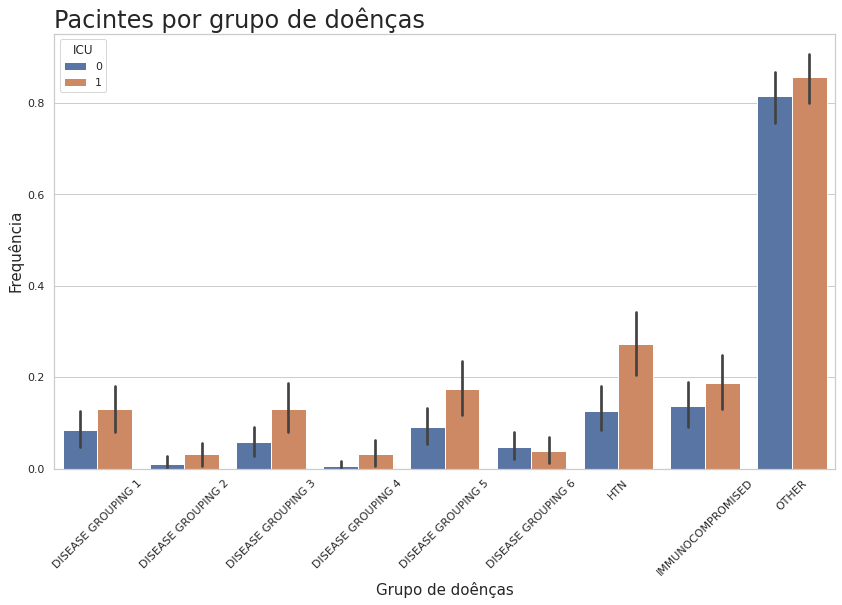

In [ ]:
sns.barplot(x='variable', y='value', data=dados_doencas.melt(id_vars='ICU'),
            hue='ICU')
plt.title('Pacintes por grupo de doênças', fontsize=24, loc='left')
plt.xlabel('Grupo de doênças', fontsize=15)
plt.ylabel('Frequência', fontsize=15)
plt.xticks(rotation=45);

Com exceção do grupo de doênças 6 os pacientes que foram para UTI apresentam maior frequência por grupo de doênças;

Obs: O mesmo paciente pode estar em mais de um grupo de doênças.

A coluna DISEASE GROUPING 6 é passível de ser retirada do modelo de Machine Learning por ser uma exceção a regra observada.

### 3.3.1 Qual o número médio de grupo de doênças por paciente?

In [ ]:
'''
Calculo do número médio de grupo de doênça considerando os pacientes que estão 
em pelo menos um grupo
'''
_ = round(pd.Series(dados.query('ICU == 0').drop_duplicates('PATIENT_VISIT_IDENTIFIER').iloc[:, 4:13].sum(axis=1).values).replace({0: None}).mean())
print(f'''
Os pacientes que não foram para a UTI e que estão em algum grupo de doênça em
média estão em {_} grupos.
''')


Os pacientes que não foram para a UTI e que estão em algum grupo de doênça em
média estão em 2 grupos.



In [ ]:
'''
Calculo do número médio de grupo de doênça considerando os pacientes que estão 
em pelo menos um grupo
'''
_ = round(pd.Series(dados.query('ICU == 0').drop_duplicates('PATIENT_VISIT_IDENTIFIER').iloc[:, 4:13].sum(axis=1).values).replace({0: None}).mean())
print(f'''
Os pacientes que foram para a UTI e que estão em algum grupo de doênça em
média estão em {_} grupos.
''')


Os pacientes que foram para a UTI e que estão em algum grupo de doênça em
média estão em 2 grupos.



### 3.3.2 Sumarização dos resultados

Variáveis passíveis de serem retiradas do modelo de Machine Learning por apresentar um exceção a regra observada na distribuição dos grupos de pacientes (foram e não forma para UTI).

1. DISEASE GROUPING 6

## 3.4 Sinais Vitais

Descrião das colunas

BLOODPRESSURE_DIASTOLIC: Pressão sanguínia diastólica

BLOODPRESSURE_SISTOLIC: Pressão sanguínia sistólica

HEART_RATE: Batimentos cardíacos

RESPIRATORY_RATE: Frequência respiratória 

TEMPERATURE: Temperatura corporal

OXYGEN_SATURATION: Saturação de oxigênio

Cada coluna possui as seguintes variações de registro: mean, median, max, min, diff and relative diff;


**Decisão**
1. Os pacientes que foram para a UTI na primeira janela (WINDOW == 0-2) não serão considerados, pois os exames podem ter ocorrido depois de os pacientes terem sido internados.
2. Dado o número de colunas a visualição terá apenas uma amostra como exemplo para o teste de distribuição.

In [ ]:
'''
sinais_vitais_colunas: Identificação geral das colunas referente aos sinais vitais
'''
sinais_vitais_colunas = ['BLOODPRESSURE_DIASTOLIC', 'BLOODPRESSURE_SISTOLIC',
                         'HEART_RATE', 'RESPIRATORY_RATE', 'TEMPERATURE',
                         'OXYGEN_SATURATION']

In [ ]:
'''
sinais_vitais: DataFrame com as colunas referente aos sinais vitais dos pacientes,
considerando os dados da primeira janela, os registros com valores NaN serão
preenchidos com os dados da linha subsequente
'''
sinais_vitais = dados_limpos.iloc[:, 192:]
sinais_vitais.head()

,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
3,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
5,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.037037,-0.538462,-0.537736,-0.517241,-0.196429,0.815789,0.030928,-0.3750,-0.401709,-0.428571,0.252747,0.919192,-0.247863,-0.567568,-0.626866,-0.575758,-0.333333,0.842105,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


In [ ]:
# Número de colunas
sinais_vitais.shape[1]

37

In [ ]:
# Número de linhas com o método melt
sinais_vitais.melt().shape[0]

12950

In [ ]:
# Número de linhas para cada coluna com o método melt
sinais_vitais.melt().shape[0] / sinais_vitais.shape[1]

350.0

In [ ]:
'''
linhas_melt: Número de linhas que abrange o grupo das seis colunas referente a 
MEAN, MEDIAN, MIN, MAX, DIFF e DIFF_RELL após aplicar o método melt
'''
linhas_colunas_melt = int((sinais_vitais.melt().shape[0] / sinais_vitais.shape[1]) * 6)
linhas_colunas_melt

2100

In [ ]:
'''
sinais_vitais_melt: Alteração do formato dos dados referente aos sinais vitais para 
visualização dos dados
'''
sinais_vitais_melt = sinais_vitais.melt(id_vars='ICU')
sinais_vitais_melt.head()

,ICU,variable,value
0,1,BLOODPRESSURE_DIASTOLIC_MEAN,0.086420
1,1,BLOODPRESSURE_DIASTOLIC_MEAN,-0.489712
2,0,BLOODPRESSURE_DIASTOLIC_MEAN,0.012346
3,0,BLOODPRESSURE_DIASTOLIC_MEAN,0.333333
4,0,BLOODPRESSURE_DIASTOLIC_MEAN,-0.037037


### 3.4.1 MEAN

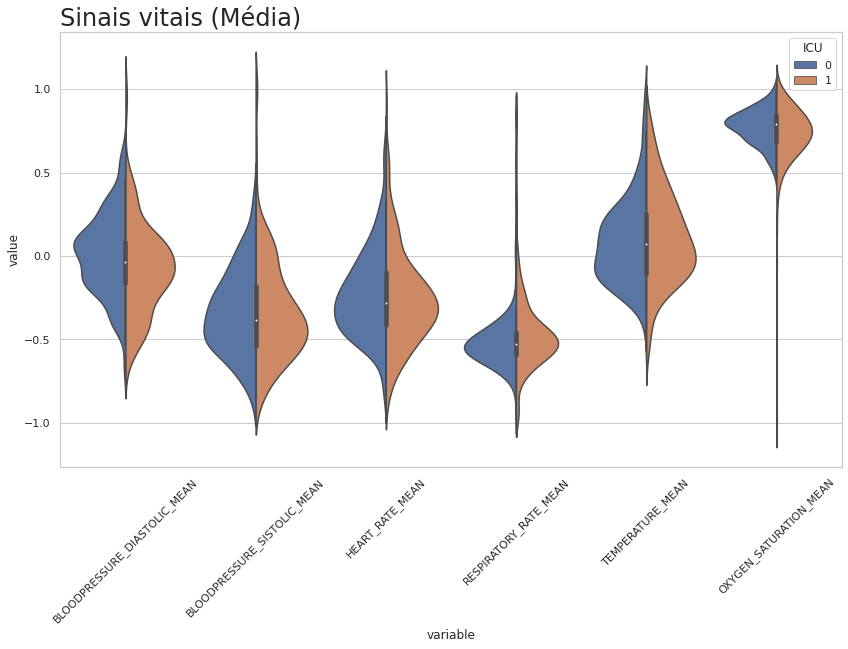

In [ ]:
sns.violinplot(x='variable', y='value', 
               data=sinais_vitais_melt.iloc[0:linhas_colunas_melt],
               hue='ICU', split=True)
plt.xticks(rotation=45)
plt.title('Sinais vitais (Média)', loc='left', fontsize=24);



---



In [ ]:
# Teste de normalidade da variável que visualmente está mais próxima de uma 
# distribuição normal no gráfico acima
teste_normalidade(sinais_vitais, 'HEART_RATE_MEAN', 'HEART_RATE_MEAN')


P-value do teste de normalidade da varirável HEART_RATE_MEAN: 0.00
P-value < 0.05 = True
Não se trata de uma distribuição normal.





---



In [ ]:
teste_ranksums_colunas(sinais_vitais, sinais_vitais_colunas, 'MEAN')

                    TESTES RANKSUMS

Foi para UTI x Não foi para UTI


Coluna: BLOODPRESSURE_DIASTOLIC_MEAN
P-value: 0.00 
P-value < 0.05 = True
Resultado: Mesma distribuição = NÃO.


Coluna: BLOODPRESSURE_SISTOLIC_MEAN
P-value: 0.62 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.


Coluna: HEART_RATE_MEAN
P-value: 0.28 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.


Coluna: RESPIRATORY_RATE_MEAN
P-value: 0.02 
P-value < 0.05 = True
Resultado: Mesma distribuição = NÃO.


Coluna: TEMPERATURE_MEAN
P-value: 0.24 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.


Coluna: OXYGEN_SATURATION_MEAN
P-value: 0.00 
P-value < 0.05 = True
Resultado: Mesma distribuição = NÃO.





---



#### 3.4.1.1 Mesma distribuição

1. BLOODPRESSURE_SISTOLIC_MEAN
2. HEART_RATE_MEAN
3. TEMPERATURE_MEAN

Obs: As igualdade de distribuição das demais colunas será verificada mais a frente.



---



## 3.5 Exames de Sangue

Descrição/ tradução das colunas

ALBUMIN: Albumina

BE_ARTERIAL

BE_VENOUS

BIC_ARTERIAL

BIC_VENOUS

BILLIRUBIN: Bilirrubina

BLAST

CALCIUM: Cálcio

CREATININ: Creatina

FFA

GGT

GLUCOSE: Glicose

HEMATOCRITE: Hematócrito

HEMOGLOBIN: Hemoglobina

INR

LACTATE: Lactato

LEUKOCYTES: Leucócitos

LINFOCITOS: Linfócitos

NEUTROPHILES: Neutrófilos

P02_ARTERIAL

P02_VENOUS

PC02_ARTERIAL

PC02_VENOUS

PCR

PH_ARTERIAL

PH_VENOUS

PLATELETS: Placas

POTASSIUM: Potássio

SAT02_ARTERIAL

SAT02_VENOUS

SODIUM: Sódio

TGO

TGP

TTPA: Tempo de tromboplastina parcial ativa

UREA: Uréia

DIMER

Cada coluna possui as seguintes variações de registro: mean, median, max, min e diff;

**Decisão**
1. Os pacientes que foram para a UTI na primeira janela (WINDOW == 0-2) não serão considerados, pois os exames podem ter ocorrido depois de os pacientes terem sido internados.
2. Dado o número de colunas a visualição terá apenas uma amostra como exemplo para o teste de distribuição.

In [ ]:
'''
exames_sangue: DataFrame com as colunas referente aos exames de sangue dos pacientes.
'''
exames_sangue = dados_limpos.iloc[:, 12:]
exames_sangue.drop(exames_sangue.iloc[:, 180:-1], axis=1, inplace=True)
exames_sangue.head()

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,ICU
0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,...,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.345679,-1.0,-0.028571,-0.028571,-0.028571,-0.028571,-1.0,-0.997201,-0.997201,-0.997201,-0.997201,-1.0,-0.990854,-0.990854,-0.990854,-0.990854,-1.0,-0.825613,-0.825613,-0.825613,-0.825613,-1.0,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.994912,-0.994912,-0.994912,-0.994912,-1.0,1
2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-1.0,...,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.345679,-1.0,0.085714,0.085714,0.085714,0.085714,-1.0,-0.995428,-0.995428,-0.995428,-0.995428,-1.0,-0.986662,-0.986662,-0.986662,-0.986662,-1.0,-0.846633,-0.846633,-0.846633,-0.846633,-1.0,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0,1
3,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,-0.972789,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.326531,0.326531,0.326531,0.326531,-1.0,...,0.939394,0.939394,0.939394,-1.0,0.580247,0.580247,0.580247,0.580247,-1.0,0.200000,0.200000,0.200000,0.200000,-1.0,-0.989549,-0.989549,-0.989549,-0.989549,-1.0,-0.956555,-0.956555,-0.956555,-0.956555,-1.0,-0.846633,-0.846633,-0.846633,-0.846633,-1.0,-0.937349,-0.937349,-0.937349,-0.937349,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0,0
4,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,-0.935113,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-1.0,...,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.345679,-1.0,0.142857,0.142857,0.142857,0.142857,-1.0,-0.998507,-0.998507,-0.998507,-0.998507,-1.0,-0.991235,-0.991235,-0.991235,-0.991235,-1.0,-0.846633,-0.846633,-0.846633,-0.846633,-1.0,-0.903614,-0.903614,-0.903614,-0.903614,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0
5,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-1.0,...,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.

In [ ]:
'''
exames_sangue_melt: Colunas referente aos exames de sangue ordenados pela linha
'''
exames_sangue_melt = exames_sangue.melt(id_vars='ICU')

In [ ]:
'''
exames_sangue_colunas: Informações que se repetem nas colunas referente aos exames 
de sangue
'''
exames_sangue_colunas = ['MEDIAN', 'MEAN', 'MIN', 'MAX', 'DIFF']

In [ ]:
# Número de colunas
exames_sangue.shape[1]

181

In [ ]:
# Número de linhas com o método melt
exames_sangue.melt().shape[0]

63350

In [ ]:
# Número de linhas ocupadas por cada coluna ao utilizar o método melt
# Essa informação será utilizada para plotagem dos gráficos
exames_sangue.melt(id_vars='ICU').shape[0] / ((exames_sangue.shape[1]) - 1)

350.0

In [ ]:
'''
linhas_colunas_melt_2: Número de linhas para plotagem dos gráficos a partir do 
método melt
'''
linhas_colunas_melt_2 = int((exames_sangue.melt(id_vars='ICU').shape[0] / ((exames_sangue.shape[1]) - 1)) * 5)
linhas_colunas_melt_2

1750

### 3.5.1 ALBUMIN



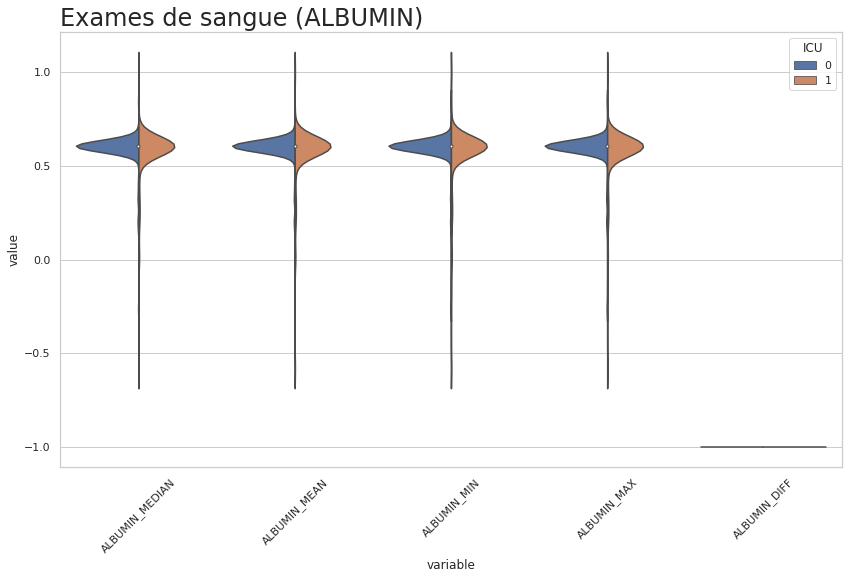

In [ ]:
sns.violinplot(x='variable', y='value', 
               data=exames_sangue_melt.iloc[0:linhas_colunas_melt_2],
               hue='ICU', split=True)
plt.xticks(rotation=45)
plt.title('Exames de sangue (ALBUMIN)', loc='left', fontsize=24);



---



In [ ]:
teste_normalidade(exames_sangue, 'ALBUMIN_DIFF', 'ALBUMIN_DIFF')


P-value do teste de normalidade da varirável ALBUMIN_DIFF: 0.00
P-value < 0.05 = True
Não se trata de uma distribuição normal.





---



In [ ]:
teste_ranksums_colunas(exames_sangue, exames_sangue_colunas, False, 'ALBUMIN')

                    TESTES RANKSUMS

Foi para UTI x Não foi para UTI


Coluna: ALBUMIN_MEDIAN
P-value: 0.43 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.


Coluna: ALBUMIN_MEAN
P-value: 0.43 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.


Coluna: ALBUMIN_MIN
P-value: 0.43 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.


Coluna: ALBUMIN_MAX
P-value: 0.43 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.


Coluna: ALBUMIN_DIFF
P-value: 1.00 
P-value < 0.05 = False
Resultado: Mesma distribuição = SIM.



#### 3.5.1.1 Mesma distribuição

1. ALBUMIN_MEDIAN
2. ALBUMIN_MEAN
3. ALBUMIN_MIN
4. ALBUMIN_MAX
5. ALBUMIN_DIFF

## 3.6 Variáveis com a mesma distribuição

Verificação da igualdade da distribuição de todas as colunas do DataFrame

In [ ]:
# Binarizando a coluna AGE_PERCENTIL
dados_limpos = pd.get_dummies(dados_limpos['AGE_PERCENTIL']).merge(dados_limpos, right_index=True,
                                                    left_index=True)

# Excluíndo a coluna original
dados_limpos.drop('AGE_PERCENTIL', axis=1, inplace=True)

In [ ]:
'''
colunas_mesma_distribuição: Lista com todas as colunas que apresentam a mesma
distribuição nos grupos que foram e não foram para UTI
'''
colunas_mesma_distribuicao = mesma_distribuicao_colunas(dados_limpos)

Conferência das colunas que apresentam a mesma distribuição observada nos tópicos anteriores.

In [ ]:
# teste 1 | Sinais vitais
for i in ['BLOODPRESSURE_SISTOLIC_MEAN', 'HEART_RATE_MEAN', 'TEMPERATURE_MEAN']:
 print(i in colunas_mesma_distribuicao)

True
True
True


In [ ]:
# teste 2 | Exames de sangue
for i in ['ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 
          'ALBUMIN_DIFF']:
  print(i in colunas_mesma_distribuicao)

True
True
True
True
True


# 4 Modelos de Machine Learning

**Objetivo**: Identificar qual o melhor modelo de Machine Learning para o problema investigado. 

## 4.1 Modelo considerando todas as colunas

### 4.1.1 [Dummy Classifier](https://sklearn.org/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

In [ ]:
roda_modelo_cv(dados_limpos, modelo=DummyClassifier(), 
                 descricao_modelo='Dummy Classifier')

AUC teste/ treino: 0.51 - 0.50


(0.5110510286003708, 0.4989943598166446)

### 4.1.2 [Logistic Regression](https://sklearn.org/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

In [ ]:
roda_modelo_cv(dados_limpos, modelo=LogisticRegression(max_iter=300), 
                 descricao_modelo='Logistic Regression')

AUC teste/ treino: 0.75 - 0.86


(0.7451907140393982, 0.8625747256956546)

### 4.1.3 [Decision Tree Classifier](https://sklearn.org/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [ ]:
roda_modelo_cv(dados_limpos)

AUC teste/ treino: 0.61 - 1.00


(0.6149395852191905, 1.0)

In [ ]:
'''
auc_teste_tree: Lista com os resultados do AUC médio de teste para cada nó do modelo 
de árvore
auc_treino_tree: Lista com os resultados do AUC médio de treino para cada nó do 
modelo de árvore
'''
auc_teste_tree = list()
auc_treino_tree = list()
for i in range(1, 10):
  teste, treino = roda_modelo_cv(dados_limpos, modelo=DecisionTreeClassifier(max_depth=i), 
                 descricao_modelo='Decision Tree Classifier')
  auc_teste_tree.append(teste)
  auc_treino_tree.append(treino)

AUC teste/ treino: 0.59 - 0.65
AUC teste/ treino: 0.67 - 0.75
AUC teste/ treino: 0.66 - 0.82
AUC teste/ treino: 0.66 - 0.87
AUC teste/ treino: 0.65 - 0.91
AUC teste/ treino: 0.62 - 0.94
AUC teste/ treino: 0.61 - 0.96
AUC teste/ treino: 0.60 - 0.98
AUC teste/ treino: 0.59 - 0.99


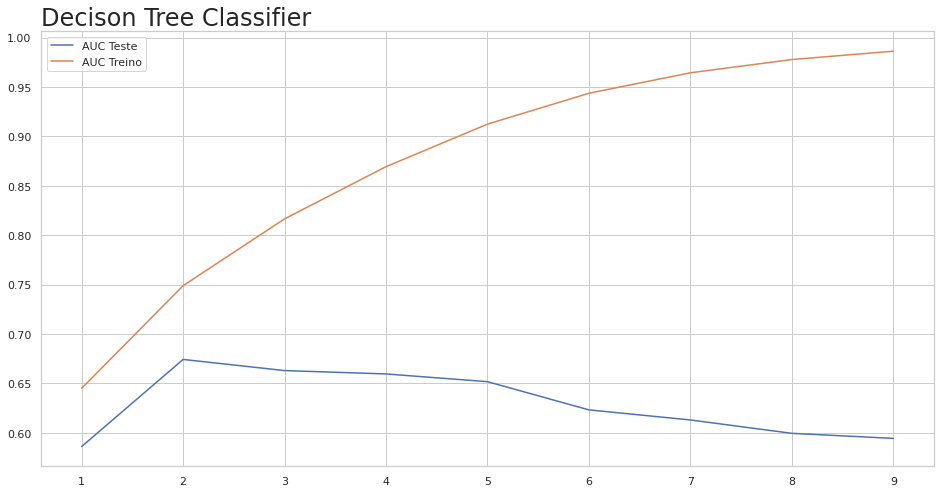

In [ ]:
curva_auc(auc_teste_tree, auc_treino_tree, 'Decison Tree Classifier')

Os dados do AUC médio de teste retornam um melhor índice até o 2 nó. 

### 4.1.4 [Random Forest Classifier](https://sklearn.org/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [ ]:
roda_modelo_cv(dados_limpos, modelo=RandomForestClassifier())

AUC teste/ treino: 0.79 - 1.00


(0.7889958214793741, 1.0)

In [ ]:
'''
auc_teste_forest: Lista com os resultados do AUC médio de teste para cada nó do 
modelo Random Forest Classifier
auc_treino_forest: Lista com os resultados do AUC médio de treino para cada nó do 
modelo Random Forest Cassifier
'''
auc_teste_forest = list()
auc_treino_forest = list()
for i in range(1, 10):
  teste, treino = roda_modelo_cv(dados_limpos, modelo=RandomForestClassifier(max_depth=i), 
                 descricao_modelo='Random Forest Classifier')
  auc_teste_forest.append(teste)
  auc_treino_forest.append(treino)

AUC teste/ treino: 0.75 - 0.85
AUC teste/ treino: 0.76 - 0.89
AUC teste/ treino: 0.78 - 0.93
AUC teste/ treino: 0.78 - 0.97
AUC teste/ treino: 0.79 - 0.99
AUC teste/ treino: 0.79 - 1.00
AUC teste/ treino: 0.79 - 1.00
AUC teste/ treino: 0.79 - 1.00
AUC teste/ treino: 0.79 - 1.00


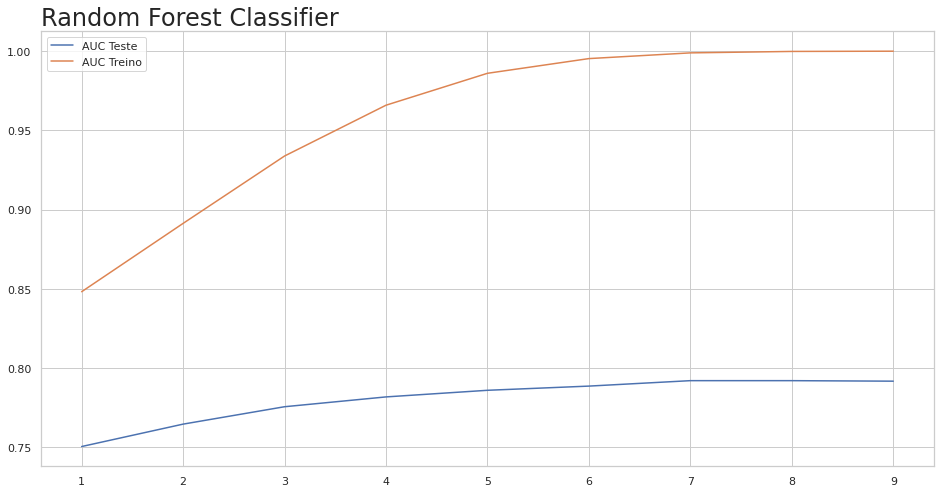

In [ ]:
curva_auc(auc_teste_forest, auc_treino_forest, 'Random Forest Classifier')

O modelo se mostra menos suscetível a overfit.

### 4.1.5 [Support Vector Machine](https://sklearn.org/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [ ]:
roda_modelo_cv(dados_limpos, modelo=SVC())

AUC teste/ treino: 0.77 - 0.82


(0.7705243895210999, 0.8246524075417083)

### 4.1.6 Observações

O modelo Random Forest Classifier retornou um melhor índice AUC, sendo menos susetível a overtif, porém requer maiores recursos de processamento.

## 4.2 Modelo desconsiderando as colunas que apresentam a mesma distribuição

In [ ]:
'''
dados_limpos_2: Cópia dos dados limpos desconsiderando as colunas que possuem a 
mesma distribuição para os pacientes que foram e não forma para UTI
'''
dados_limpos_2 = dados_limpos.copy()
dados_limpos_2.drop(colunas_mesma_distribuicao, axis=1, inplace=True)

In [ ]:
dados_limpos_2.head()

,AGE_ABOVE65,HTN,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,RESPIRATORY_RATE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,RESPIRATORY_RATE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,HEART_RATE_MIN,OXYGEN_SATURATION_MIN,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,RESPIRATORY_RATE_DIFF,RESPIRATORY_RATE_DIFF_REL,ICU
0,1,0.0,0.183673,0.183673,0.183673,0.183673,-0.868365,-0.868365,-0.868365,-0.868365,-0.945093,-0.945093,-0.945093,-0.945093,1.000000,1.000000,1.000000,1.000000,-0.914938,-0.914938,-0.914938,-0.914938,-0.868747,-0.868747,-0.868747,-0.868747,-0.754601,-0.754601,-0.754601,-0.754601,-0.875236,-0.875236,-0.875236,-0.875236,-0.518519,-0.518519,-0.518519,-0.518519,-0.028571,-0.028571,-0.028571,-0.028571,-0.997201,-0.997201,-0.997201,-0.997201,-0.836145,-0.836145,-0.836145,-0.836145,-0.994912,-0.994912,-0.994912,-0.994912,0.086420,-0.593220,0.736842,0.086420,-0.586207,0.736842,0.237113,-0.162393,0.898990,-0.636364,-0.420290,-1.000000,-1.000000,1
2,0,0.0,0.357143,0.357143,0.357143,0.357143,-0.912243,-0.912243,-0.912243,-0.912243,-0.958528,-0.958528,-0.958528,-0.958528,1.000000,1.000000,1.000000,1.000000,-0.908714,-0.908714,-0.908714,-0.908714,-0.412965,-0.412965,-0.412965,-0.412965,-0.754601,-0.754601,-0.754601,-0.754601,-0.939887,-0.939887,-0.939887,-0.939887,-0.703704,-0.703704,-0.703704,-0.703704,0.085714,0.085714,0.085714,0.085714,-0.995428,-0.995428,-0.995428,-0.995428,-0.836145,-0.836145,-0.836145,-0.836145,-0.978029,-0.978029,-0.978029,-0.978029,-0.489712,-0.645951,0.935673,-0.506173,-0.517241,0.947368,-0.525773,-0.111111,0.959596,-0.575758,0.101449,-0.764706,-0.756272,1
3,0,0.0,0.326531,0.326531,0.326531,0.326531,-0.968861,-0.968861,-0.968861,-0.968861,-0.316589,-0.316589,-0.316589,-0.316589,-0.828421,-0.828421,-0.828421,-0.828421,-0.836100,-0.836100,-0.836100,-0.836100,-0.784714,-0.784714,-0.784714,-0.784714,-0.779141,-0.779141,-0.779141,-0.779141,-0.503592,-0.503592,-0.503592,-0.503592,-0.777778,-0.777778,-0.777778,-0.777778,0.200000,0.200000,0.200000,0.200000,-0.989549,-0.989549,-0.989549,-0.989549,-0.937349,-0.937349,-0.937349,-0.937349,-0.978029,-0.978029,-0.978029,-0.978029,0.012346,-0.457627,0.684211,0.012346,-0.448276,0.684211,0.175258,-0.384615,0.878788,-0.515152,-0.420290,-1.000000,-1.000000,0
4,0,0.0,0.357143,0.357143,0.357143,0.357143,-0.913659,-0.913659,-0.913659,-0.913659,-0.938084,-0.938084,-0.938084,-0.938084,1.000000,1.000000,1.000000,1.000000,-0.641079,-0.641079,-0.641079,-0.641079,-0.812725,-0.812725,-0.812725,-0.812725,-0.754601,-0.754601,-0.754601,-0.754601,-0.990926,-0.990926,-0.990926,-0.990926,-0.592593,-0.592593,-0.592593,-0.592593,0.142857,0.142857,0.142857,0.142857,-0.998507,-0.998507,-0.998507,-0.998507,-0.903614,-0.903614,-0.903614,-0.903614,-1.000000,-1.000000,-1.000000,-1.000000,0.333333,-0.593220,0.868421,0.333333,-0.586207,0.868421,0.443299,0.196581,0.939394,-0.575758,0.072464,-0.882353,-0.870968,0
5,0,0.0,0.357143,0.357143,0.357143,0.357143,-0.891012,-0.891012,-0.891012,-0.891012,-0.958528,-0.958528,-0.958528,-0.958528,1.000000,1.000000,1.000000,1.000000,-0.340249,-0.340249,-0.340249,-0.340249,-0.846339,-0.846339,-0.846339,-0.846339,-0.754601,-0.754601,-0.754601,-0.754601,-0.997732,-0.997732,-0.997732,-0.997732,-0.666667,-0.666667,-0.666667,-0.666667,0.085714,0.085714,0.085714,0.085714,-0.997947,-0.997947,-0.997947,-0.99

In [ ]:
# Linhas e colunas
dados_limpos_2.shape

(350, 68)

In [ ]:
# Proporção após desconsiderar colunas com a mesma distribuição nos grupos de
# paciente que foram e não formam para UTI
print(f'''
Proporção de colunas desconsiderando aquelas que apresentam a mesma distribuição
para os pacientes que foram e não foram para UTI: {round(dados_limpos_2.shape[1] / dados_limpos.shape[1] * 100)}%
''')


Proporção de colunas desconsiderando aquelas que apresentam a mesma distribuição
para os pacientes que foram e não foram para UTI: 29%



### 4.2.1 Dummy Classifier

In [ ]:
roda_modelo_cv(dados_limpos_2, modelo=DummyClassifier(), 
                 descricao_modelo='Dummy Classifier')

AUC teste/ treino: 0.51 - 0.50


(0.5110510286003708, 0.4989943598166446)

### 4.2.2 Logistic Regression

In [ ]:
roda_modelo_cv(dados_limpos_2, modelo=LogisticRegression(max_iter=300), 
                 descricao_modelo='Logistic Regression')

AUC teste/ treino: 0.77 - 0.82


(0.7700713662226822, 0.8203068242372521)

### 4.2.3 Decision Tree Classifier

In [ ]:
roda_modelo_cv(dados_limpos_2)

AUC teste/ treino: 0.61 - 1.00


(0.614498415879995, 1.0)

In [ ]:
'''
auc_teste_tree: Lista com os resultados do AUC médio de teste para cada nó do modelo 
de árvore
auc_treino_tree: Lista com os resultados do AUC médio de treino para cada nó do 
modelo de árvore
'''
auc_teste_tree = list()
auc_treino_tree = list()
for i in range(1, 10):
  teste, treino = roda_modelo_cv(dados_limpos_2, modelo=DecisionTreeClassifier(max_depth=i), 
                 descricao_modelo='Decision Tree Classifier')
  auc_teste_tree.append(teste)
  auc_treino_tree.append(treino)

AUC teste/ treino: 0.59 - 0.65
AUC teste/ treino: 0.69 - 0.75
AUC teste/ treino: 0.68 - 0.82
AUC teste/ treino: 0.67 - 0.87
AUC teste/ treino: 0.65 - 0.91
AUC teste/ treino: 0.63 - 0.94
AUC teste/ treino: 0.62 - 0.96
AUC teste/ treino: 0.61 - 0.98
AUC teste/ treino: 0.61 - 0.99


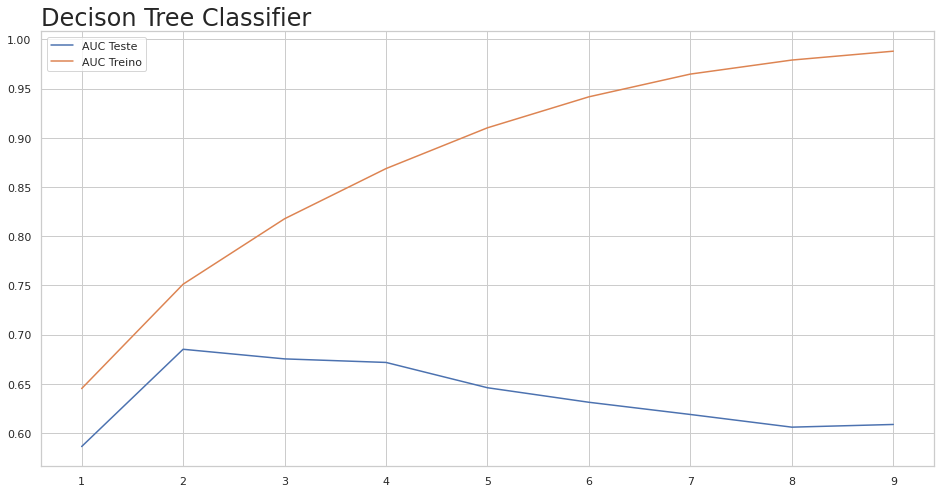

In [ ]:
curva_auc(auc_teste_tree, auc_treino_tree, 'Decison Tree Classifier')

Os dados do AUC médio de teste retornam um melhor índice até o 2 nó. 

### 4.2.4 Random Forest Classifier

In [ ]:
roda_modelo_cv(dados_limpos_2, modelo=RandomForestClassifier())

AUC teste/ treino: 0.78 - 1.00


(0.7791361561920772, 1.0)

In [ ]:
'''
auc_teste_forest: Lista com os resultados do AUC médio de teste para cada nó do 
modelo Random Forest Classifier
auc_treino_forest: Lista com os resultados do AUC médio de treino para cada nó do 
modelo Random Forest Cassifier
'''
auc_teste_forest = list()
auc_treino_forest = list()
for i in range(1, 10):
  teste, treino = roda_modelo_cv(dados_limpos_2, modelo=RandomForestClassifier(max_depth=i), 
                 descricao_modelo='Random Forest Classifier')
  auc_teste_forest.append(teste)
  auc_treino_forest.append(treino)

AUC teste/ treino: 0.74 - 0.82
AUC teste/ treino: 0.76 - 0.87
AUC teste/ treino: 0.77 - 0.91
AUC teste/ treino: 0.77 - 0.95
AUC teste/ treino: 0.78 - 0.98
AUC teste/ treino: 0.78 - 0.99
AUC teste/ treino: 0.78 - 1.00
AUC teste/ treino: 0.78 - 1.00
AUC teste/ treino: 0.78 - 1.00


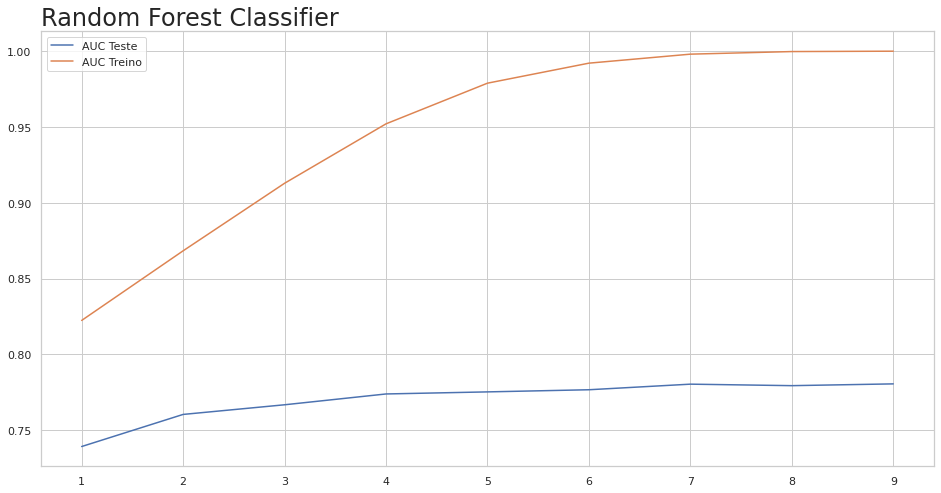

In [ ]:
curva_auc(auc_teste_forest, auc_treino_forest, 'Random Forest Classifier')

### 4.2.5 Support Vector Machine

In [ ]:
roda_modelo_cv(dados_limpos_2, modelo=SVC())

AUC teste/ treino: 0.77 - 0.81


(0.7704704001250055, 0.8123148458862413)

### 4.2.6 Observações

Desconsiderando as colunas com a mesma distribuição para os grupos que foram e não foram para a UTI o modelo Random Forest Classifier retornou um melhor índice AUC, sendo menos susetível a overtif, porém requer maiores recursos de processamento.

## 4.3 Dados completos X Colunas desconsideradas

Dados completos:
1. Logistic Regression: AUC teste/ treino: 0.75 - 0.86
2. Decision Tree Classifier: AUC teste/ treino: 0.61 - 1.00
3. Random Forest: AUC teste/ treino: 0.79 - 1.00
4. Suport Vector Machine: AUC teste/ treino: 0.77 - 0.82

Colunas desconsideradas: 
1. Logistic Regression: AUC teste/ treino: 0.77 - 0.82
2. Decisino Tree Classifier: AUC teste/ treino: 0.61 - 1.00
3. Random Forest: AUC teste/ treino: 0.78 - 1.00
4. Suport Vector Machine: AUC teste/ treino: 0.77 - 0.81

A retirada das colunas que apresentam a mesma distribuição para os pacientes que foram e não foram para UTI não impactou na capacidade de previsão do modelo de forma significativa com a amostra de dados disponível, onde melhor AUC obtiddo foi com o modelo Random Forest com os dados completos.

## 4.4 Modelo com melhor desempenho

### 4.4.1 Matriz de confusão

In [ ]:
'''
modelo_random_forest_1: Modelo de Machine Learning com os dados limpos para
facilitar a visualização das featurer importances
x_treino_1: Dados de treino do modelo
x_teste_1: Dados de teste da variável x
y_teste_1: Dads de teste da variável y
y_predito_1: Valores previsto para y
'''
modelo_random_forest_1, x_treino_1, x_teste_1, y_treino_1, y_teste_1, y_predito_1 = modelo_treino_teste(dados_limpos,
                                                                                              modelo=RandomForestClassifier(max_depth=6))

'''
modelo_random_forest_2: Modelo de Machine Learning com os dados limpos 2 para
facilitar a visualização das featurer importances
x_treino_2: Dados de treino do modelo
x_teste_2: Dados de teste da variável x
y_teste_2: Dads de teste da variável y
y_predito_2: Valores previsto para y
'''
modelo_random_forest_2, x_treino_2, x_teste_2, y_treino_2, y_teste_2, y_predito_2 = modelo_treino_teste(dados_limpos_2,
                                                                                              modelo=RandomForestClassifier(max_depth=7))

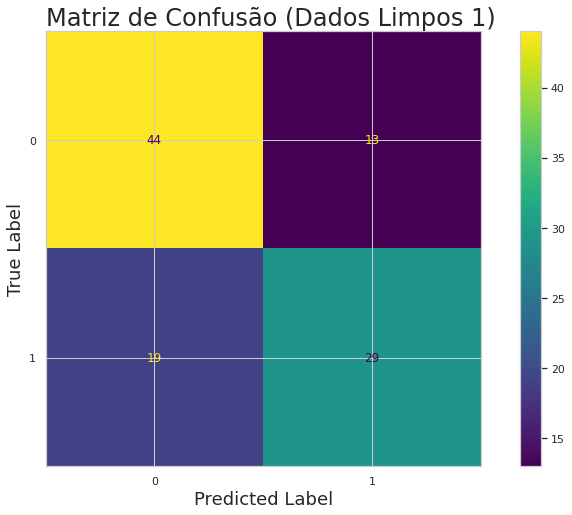

In [ ]:
# Visualização sem validação cruzada
plot_confusion_matrix(modelo_random_forest_1, x_teste_1, y_teste_1)
personaliza_grafico('Matriz de Confusão (Dados Limpos 1)', 'Predicted Label', 'True Label')



Verdadeiro positivo: Previsão positiva para um dado positivo

Verdadeiro negativo: Previsão negativa para um dado negativo

Falso positivo: Previsão positiva para um dado negativo

Falso negativo: Previsão negativa para um dado positivo


In [ ]:
print(classification_report(y_teste_1, y_predito_1))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73        57
           1       0.69      0.60      0.64        48

    accuracy                           0.70       105
   macro avg       0.69      0.69      0.69       105
weighted avg       0.69      0.70      0.69       105





---



Precision: "O número correto das previsões positivas dividida pelo total de previsões positivas, incluindo aquelas que não foram previstas corretamente."

De todas as previsões positivas a proporção de acerto. 

$precision = \frac{Verdadeiro Positivo}{Verdadeiro Positivo + Falso Positivo}$

Para o problema estudado um precision muito baixo acarreta em uma sobrecarga na ocupação de UTI's.



---



Recall = "O número correto identificado como positivo dividido pelo número de toda a amostra que deveria ter sido identificado como positivo."

$recall = \frac{Verdadeiro Positivo}{Verdadeiro Positivo + Falso Negativo}$

O recall muito baixo acarreta na desocupação indevida no encaminhamento para UTI.



---



f1-score = "Média harmônica de precision e recall".

$f1-score = \frac{2 \times (precision \times recall)}{precision + recall}$



---



### 4.4.2 Variáveis mais importantes

[Visualização de variáveis importantes](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)

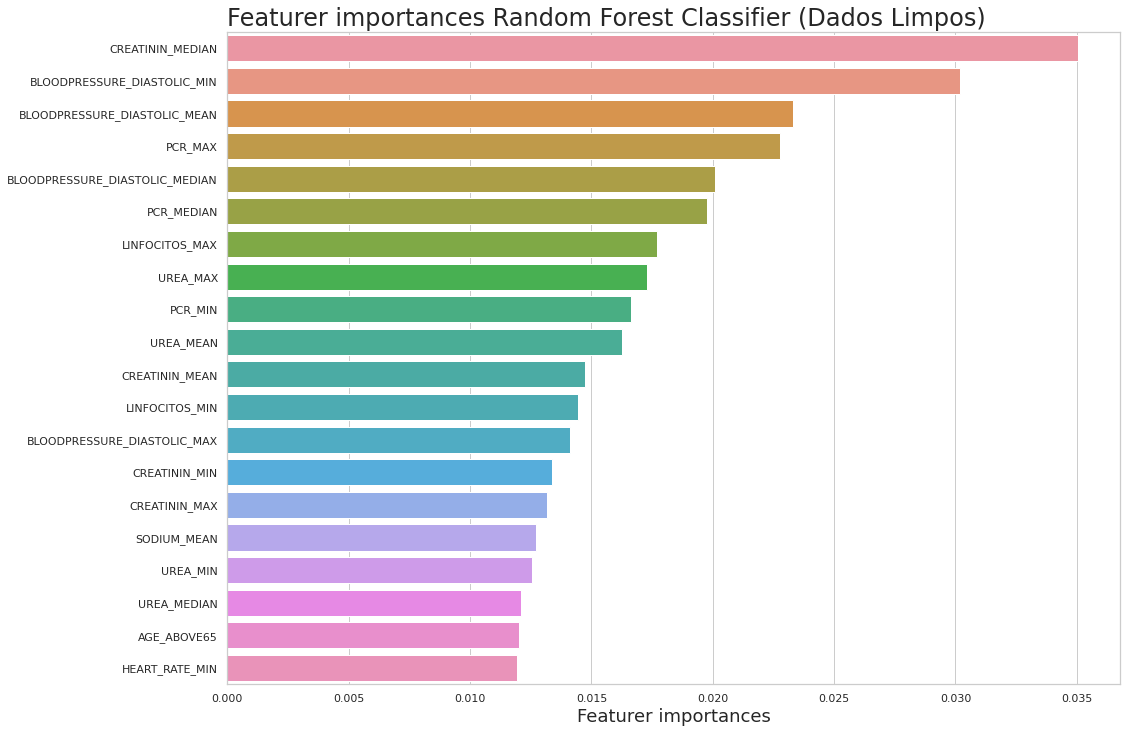

In [ ]:
_ = pd.DataFrame({'feature_importance': modelo_random_forest_1.feature_importances_,
                  'variavel': x_treino_1.columns}).sort_values('feature_importance', ascending=False)
plt.figure(figsize=(16, 12))
sns.barplot(data=_[:20], y='variavel', x='feature_importance', orient='h')
personaliza_grafico('Featurer importances Random Forest Classifier (Dados Limpos)', 
                    'Featurer importances', '')

Obs: Visualização dos 20 primeiros

Variáveis de maior impacto para classificação: 

1. Creatina mediana
2. Pressão arterial diastólica mínimo
3. Pressão arterial diastólica média

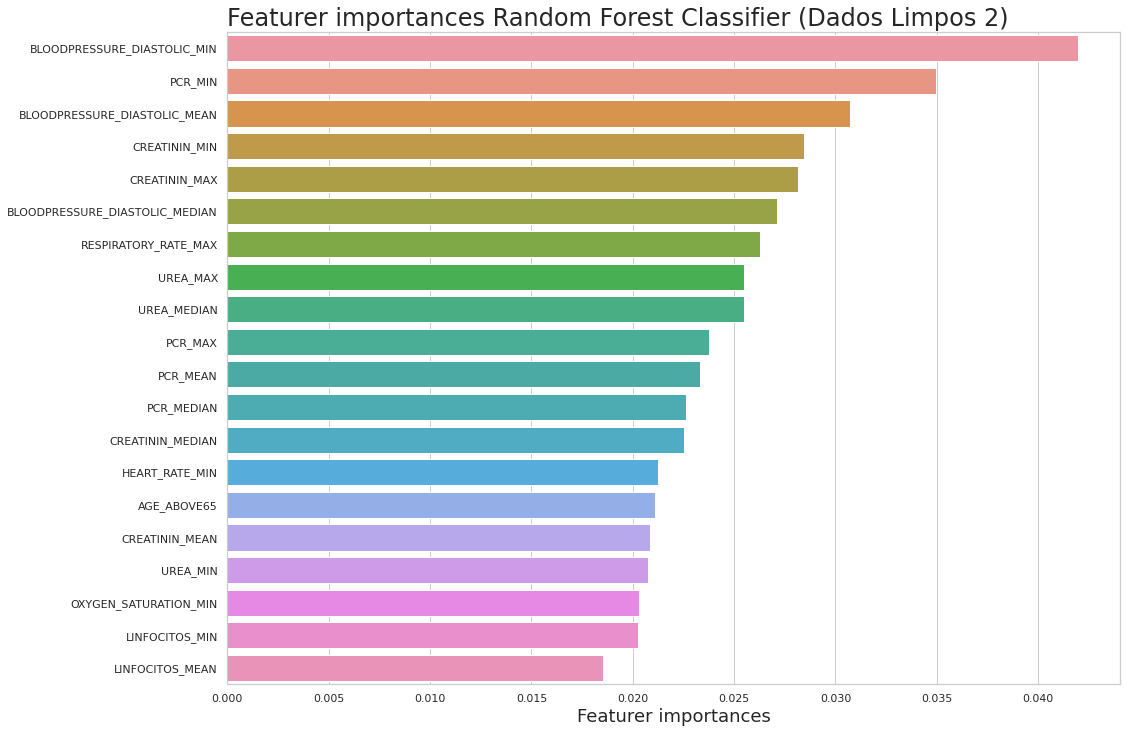

In [ ]:
_ = pd.DataFrame({'feature_importance': modelo_random_forest_2.feature_importances_,
                  'variavel': x_treino_2.columns}).sort_values('feature_importance', ascending=False)
plt.figure(figsize=(16, 12))
sns.barplot(data=_[:20], y='variavel', x='feature_importance', orient='h')
personaliza_grafico('Featurer importances Random Forest Classifier (Dados Limpos 2)', 
                    'Featurer importances', '')

Obs: Visualização dos 20 primeiros

Variáveis de maior impacto para classificação: 

1. Pressão arterial diastólica mínima
3. PCR mínimo
3. Pressão arterial diastólica média

#### 4.4.2.1 Pressão arterial diastólica

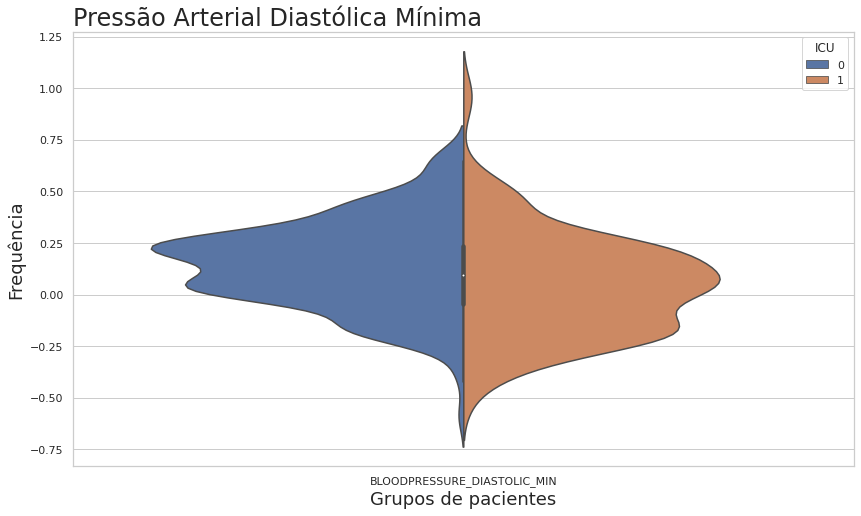

In [ ]:
sns.violinplot(x='variable', y='value', hue='ICU', 
               data=dados_limpos_2[['BLOODPRESSURE_DIASTOLIC_MIN', 'ICU']].melt(id_vars='ICU'), 
               split=True)
personaliza_grafico('Pressão Arterial Diastólica Mínima', 'Grupos de pacientes', 'Frequência');

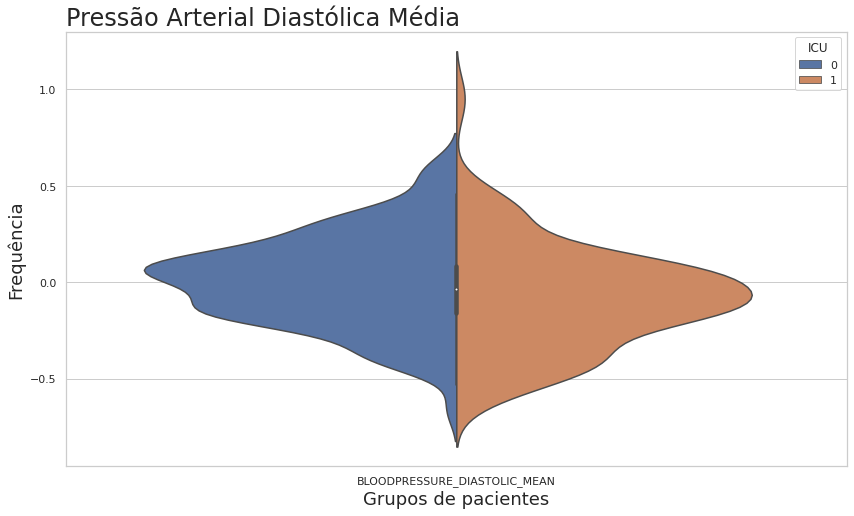

In [ ]:
sns.violinplot(x='variable', y='value', hue='ICU', 
               data=dados_limpos_2[['BLOODPRESSURE_DIASTOLIC_MEAN', 'ICU']].melt(id_vars='ICU'), 
               split=True)
personaliza_grafico('Pressão Arterial Diastólica Média', 'Grupos de pacientes', 'Frequência');

Pressão arterial diastólica 

"[...] a pressão arterial diastólica (PAD) ou “pressão mínima” ocorre no início do ciclo cardíaco e se refere à capacidade de adaptação ao volume de sangue que o coração ejetou." (OMRON, 2020)

#### 4.4.2.2 PCR mínimo

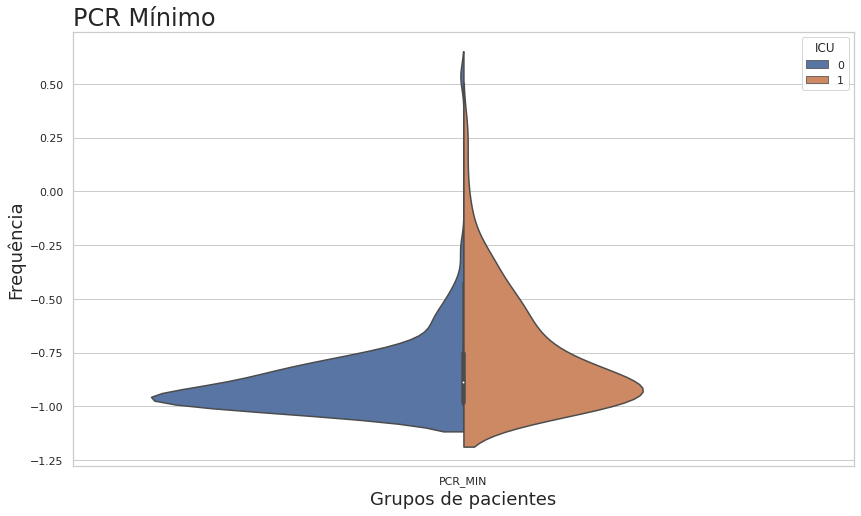

In [ ]:
sns.violinplot(x='variable', y='value', hue='ICU', 
               data=dados_limpos_2[['PCR_MIN', 'ICU']].melt(id_vars='ICU'), 
               split=True)
personaliza_grafico('PCR Mínimo', 'Grupos de pacientes', 'Frequência');

O que é PCR?

"A **proteína C-reativa**, também conhecida por PCR, é uma proteína produzida pelo fígado que, geralmente, está aumentada quando existe algum tipo de processo inflamatório ou infeccioso acontecendo no corpo, sendo um dos primeiros indicadores a estar alterado no exame de sangue, nessas situações." (BEZERRA, 2020)

#### 4.4.2.3 Creatina mediana

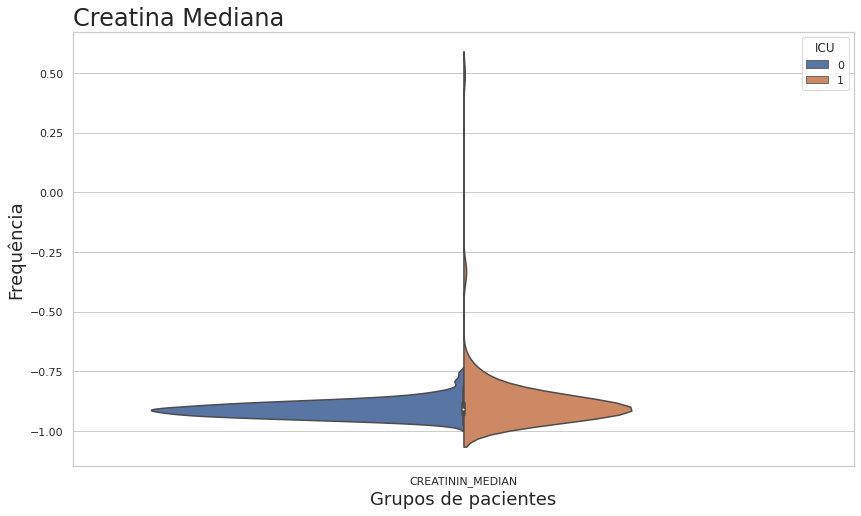

In [ ]:
sns.violinplot(x='variable', y='value', hue='ICU', 
               data=dados_limpos_2[['CREATININ_MEDIAN', 'ICU']].melt(id_vars='ICU'), 
               split=True)
personaliza_grafico('Creatina Mediana', 'Grupos de pacientes', 'Frequência');

Creatina

"A creatina é um composto produzido pelo fígado, rins e pâncreas, a partir de alguns aminoácidos (glicina, arginina, metionina). A substância também está naturalmente presente em carnes, peixes, frango, ovo, frutos do mar, leite e derivados. Em nosso organismo, ela é armazenada em grande parte nos tecidos musculoesqueléticos e, em menor quantidade, no coração, músculos lisos, cérebro e testículos. Em geral, nosso corpo produz cerca de 1 grama de creatina por dia e outro 1 grama é ingerido na dieta." (NAVAS, 2020)

Um estudo realizado com informações de pacientes admitidos em 27 de Janeiro a 12 de Fevereiro no Departamento de Infecção do Hospital Tongji em Wuhan com uma amostra de controle onde foi considerado que o PCR, Linfócitos e saturação do oxigênio como indicadores chave para previsão de pacientes que apresentam casos severos da COVID-19. (LI, MARMAR, XU, TU, YIN, TAO, CHEN, SHEN, XU, 2020)

A amostra do estudo foi estratificada segundo a figura abaixo:



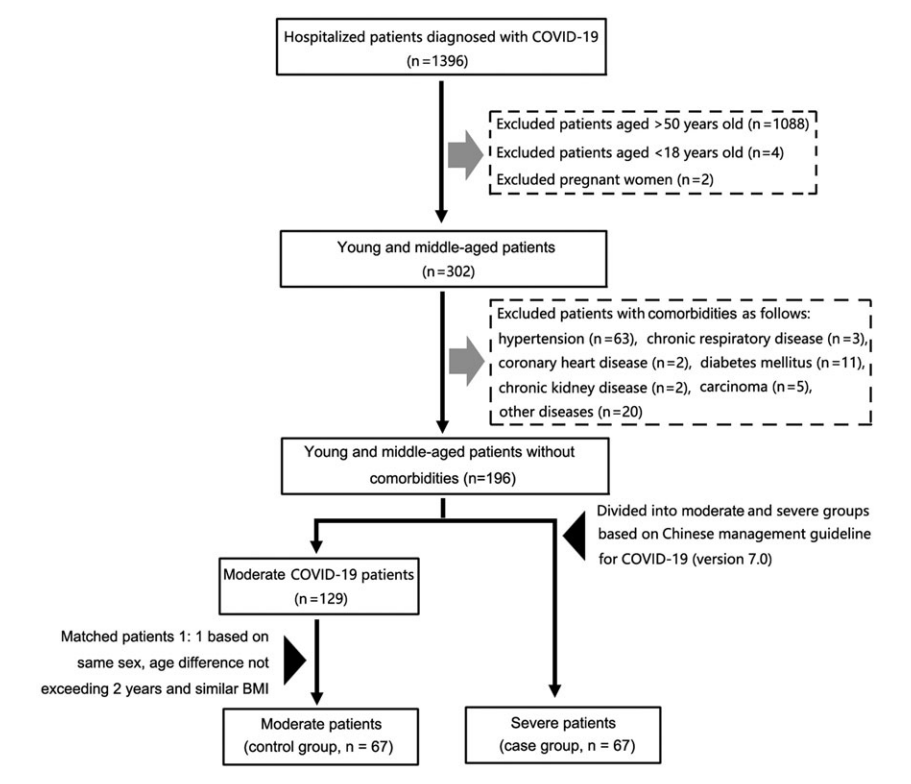

Os pesquisadores utilizaram a regressão logística para as constatações do estudo, utilizando aqui o Random Forest Classifier observa se o PCR como um fator de importância para o algoritmo, mas a pesquisa apesar de servir como um resultado comparativo, foi realizada com uma amostra diferente seguindo outros critérios de estratificação.

# 5 Considerações Finais 

Foram considerados os dados da primeira janela de exames (WINDOW = 0-2) para análise dos dados e modelagem para prever se o paciente irá ou não precisar da UTI, outra estratégia utilizada foi a criação de um segundo data frame pandas com as colunas que contenham apenas distribuições diferentes para os grupos que foram e não foram para UTI, a segunda estratégia pode não ter retornando uma melhoria nos indicadores por conta do número de registros disponíveis.

O melhor resultado obtido foi com o modelo Random Forest Classifier retornando um AUC de 79% com os dados completos, porém o recall observado foi muito baixo de 60%, o que pode acarretar no não encaminhamento de pacientes para UTI de forma indevida.

Com os indicadores obtidos não é possível aplicar o algoritmo para produção, uma boa estratégia seria testar o modelo com um maior número de dados para verificar se o AUC e o recall retornam melhores indicadores.

Também há a necessidade de validar com um profissional da área da saúde se as variáveis que mais impactaram o modelo (featurer importances) são realmente determinantes para o agravamento no estado de saúde do paciente, para que assim o algoritmo tenha a credibilidade necessária para ser utilizado como ferramenta de tomada de decisão.

Apesar de o modelo ainda não apresentar os requisitos para ser aplicado em produção, a estratégia de considerar apenas as variáveis que apresentam distribuições diferentes para os dois grupos (foi para UTI X não foi para UTI) pode ser uma boa opção para otimização ao se trabalhar com uma base de dados mais ampla.

# 6 Referências

BANERJEE, Rahul. Understanding Accuracy, Recall, Precision, F1 Scores, and Confusion Matrices. Disponível em: https://towardsdatascience.com/understanding-accuracy-recall-precision-f1-scores-and-confusion-matrices-561e0f5e328c. Acesso em: 18 Fev. 2021.

BEZERRA, Clarisse. Proteína C-reativa (PCR): o que é e porque pode estar alta. Diponível em: https://www.tuasaude.com/proteina-c-reativa/. Acesso em: 21 Fev. 2021.

Hospital Sírio Libanês. COVID-19 - Clinical Data to assess diagnosis
. Disponível em: https://www.kaggle.com/S%C3%ADrio-Libanes/covid19. Acesso em: 1 Fev. 2021.

Johns Hopkins. Coronavirus Resourse Center. Disponível em: https://coronavirus.jhu.edu/. Acesso em: 21 Fev. 2020.

LI, Xinjie; MARMAR, Tuohutaerbieke; XU, Qiang; TU, Jing; YIN, Yue; TAO, Qihui; CHEN, Huilong; SHEN, Tao, XU, Dong. Predictive indicators of severe COVID-19
independent of comorbidities and advanced
age: a nested case−control study. Disponível em: https://pdfs.semanticscholar.org/1719/1aa703d64ec40d0b39c8a14908aa35ae39ed.pdf. Acesso em: 21 Fev. 2021.

NAVAS, Daniel. Creatina ajuda a ganhar músculos. Tire suas dúvidas sobre o suplemento. Disponível em: https://www.uol.com.br/vivabem/noticias/redacao/2020/01/15/creatina-o-que-e-quando-tomar-e-quais-os-beneficios-para-o-treino.htm. Acess em: 21 Fev. 2021.

OMRON. O que é pressão arterial sistólica e diastólica? Disponível em: https://conteudo.omronbrasil.com/o-que-e-pressao-arterial-sistolica-2/. Acesso em: 21 Fev. 2021.



---

